In [4]:
#package insatLLation
!pip install pyserial
!pip install schedule

In [1]:
import serial
import datetime
import time
import schedule
import IDS
import csv
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'IDS'

## Scheduling

In [2]:
def Schedule():
    import schedule

    def job():
        print("I'm working...")

    schedule.every(10).minutes.do(job)
    schedule.every().hour.do(job)
    schedule.every().day.at("10:30").do(job)
    schedule.every().monday.do(job)
    schedule.every().wednesday.at("13:15").do(job)
    schedule.every().day.at("12:42", "Europe/Amsterdam").do(job)
    schedule.every().minute.at(":17").do(job)

    while True:
        schedule.run_pending()
        time.sleep(1)

## Arduino and BME680 
Collecting data from Serial Monitor and displaying the data in python

In [3]:
def arduino_bme680(duration_minutes):
    start_time = time.time()

    # Set the filename
    fn = "Environmental_Readings.csv"
    
    try:
        f = open(fn, "w")

        # Set the COM port
        cp = "COM9"
        
        try:
            ser = serial.Serial(cp, 9600)
        except:
            print(f"Could not open {cp}! Check if the port is available and try again.")
            return

        print("Now logging!")

        try:
            while (time.time() - start_time) < duration_minutes * 60:
                s = ser.readline()
                timestamp = datetime.now().strftime("%d/%m/%Y,%H:%M:%S.%f")[:-3]  # Get timestamp with milliseconds
                print(timestamp + "," + s.decode()[:-1])
                f.write(timestamp + "," + s.decode()[:-1])
        except KeyboardInterrupt:
            print("Logging Aborted, closing file!")
        finally:
            f.close()
            ser.close()
    except Exception as e:
        print(f"Error: {e}")

# arduino_bme680(1)


In [6]:
def modify_csv(original_filename, modified_filename):
    try:
        with open(original_filename, 'r') as original_file:
            # Skip the first two lines
            lines = original_file.readlines()[2:]

        # Specify the header
        header = ["Date", "Time", "Temperature(C)", "Pressure(hPa)", "Humidity(%rh)"]

        with open(modified_filename, 'w', newline='') as modified_file:
            # Write the header
            writer = csv.writer(modified_file)
            writer.writerow(header)

            # Write the remaining lines
            writer.writerows(csv.reader(lines))

        print(f"CSV file '{modified_filename}' has been created with the modified format.")
    except Exception as e:
        print(f"Error: {e}")




In [7]:
def Environmental_plot():
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv('Environmental_Readings_Modified_job2.csv', parse_dates=[['Date', 'Time']], dayfirst=True)

    # Create a single plot with twin y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
   

    # Plot Temperature and Humidity on the left y-axis
    color = 'tab:orange'
    ax1.set_xlabel('Date & Time')
    ax1.set_ylabel('Temperature (C) / Humidity (%rh)', color=color)
    ax1.plot(df['Date_Time'], df['Temperature(C)'], label='Temperature', marker='.', linestyle='-', color=color)
    ax1.plot(df['Date_Time'], df['Humidity(%rh)'], label='Humidity',marker='.', linestyle='-', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Set the y-axis limit for the left axis
    ax1.set_ylim([0, 60])
    
    # Create a second y-axis for Pressure on the right
    ax2 = ax1.twinx()
    color = 'tab:grey'
    ax2.set_ylabel('Pressure (hPa)', color=color)
    ax2.plot(df['Date_Time'], df['Pressure(hPa)'], label='Pressure',  marker='.', linestyle='-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Set the y-axis limit for the right axis
    ax2.set_ylim([960, 1015])

    # Show the legends at the bottom
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.5,0),loc='lower center')

    # Set grid
    ax1.grid(True)
    
    ax1.tick_params(axis='x', labelrotation=45)

    # Show the plot
    plt.title("BM680 Environmental Monitor Demo")
    plt.tight_layout()
    plt.show()

# # Call the function
# Environmental_plot()

## Interacting with IDS 


In [6]:
pwd #File location

'C:\\Users\\labrat\\Biswajit Master Project'

In [9]:
import IDS
import time
import csv
from datetime import datetime

ModuleNotFoundError: No module named 'IDS'

In [8]:
IP = "147.197.221.6"

# Setup connection to IDS
ids = IDS.Device(IP)
ids.connect()

In [9]:
# Measure on axis 1
# Internally, axes are numbered 0 to 2
axis = 0  # Axis 1

In [10]:
p = ids.system.getCurrentMode() #To check current mode
p
# ids.close()

'measurement running'

In [ ]:
# ids.system.getInitMode() #0 = High Accuracy Initialization; 1 = Quick Initialization

In [6]:
# Start alignment
ids.system.startOpticsAlignment()

# Wait until alignment is running
while not ids.adjustment.getAdjustmentEnabled():
    time.sleep(1)

# Get contrast
warningNo, contrast, baseline, mixcontent = ids.adjustment.getContrastInPermille(axis)
print("Contrast:", contrast, "Baseline:", baseline, "Mixcontent:", mixcontent)

# Stop alignment and start measurement
ids.system.stopOpticsAlignment()
while ids.system.getCurrentMode() != "system idle":
    time.sleep(1)
ids.system.setInitMode(1)  # Enable high accuracy mode
ids.system.startMeasurement()

# Wait until measurement is running
while not ids.displacement.getMeasurementEnabled():
    time.sleep(1)

AttoException: ('Error! ERR_ACTION_DENIED', 2058)

In [8]:
p = ids.system.getCurrentMode() #To check current mode
p


'measurement starting'

In [11]:
# Get position
position = ids.displacement.getAbsolutePosition(axis)
position

(0, 593337707367)

In [22]:
def Taking_pos_readings(duration_minutes):
    # Create and open a CSV file for writing
    csv_file = "pos_time_readings.csv"
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(["Date", "Time", "Position (cm)"])

        # Record start time
        start_time = time.time()
        end_time = start_time + duration_minutes * 60  # Calculate end time

        # Initialize variables for the rotating character and its index
        chars = ['.', '..', '...','....']
        char_index = 0

        # Print the initial progress
        print("Data collection in progress", end='', flush=True)

        # Run the loop for the specified data collection time
        while time.time() < end_time:
            # Get position
            warningNo, position = ids.displacement.getAbsolutePosition(axis)
            position_cm = position / 1e10  # Convert position from pm to cm

            # Get the current date and time
            now = datetime.now()
            date = now.strftime("%Y-%m-%d")
            timestamp = now.strftime("%H:%M:%S.%f")[:-3]

            # Write data to CSV file
            writer.writerow([date, timestamp, position_cm])

            # Update the rotating character
            char_index = (char_index + 1) % len(chars)

            # Calculate time left
            time_left = end_time - time.time()
            minutes_left = int(time_left / 60)
            seconds_left = int(time_left % 60)

            # Create the dynamic message
            progress_message = f"Data collection in progress{'.' * (char_index % 3)}"
            time_message = f"Time left: {minutes_left} minutes {seconds_left} seconds"

            # Print the dynamic progress message
            print(f"\r{progress_message} {time_message}", end='', flush=True)
           

            # Wait for a short duration (adjust as needed)
            time.sleep(0.001)

        print("\nData collection completed.")


In [15]:
def plot_pos_time():
        %matplotlib notebook
        # Load data from the CSV file
        import pandas as pd
        import matplotlib.pyplot as plt

        # Read the CSV file
        data = pd.read_csv("pos_time_readings_job2.csv")

        # Extract Date, Time, and Position columns
        date_time = data["Date"] + " " + data["Time"]
        position = data["Position (cm)"]

        # Convert date and time to datetime objects
        date_time = pd.to_datetime(date_time, format="%Y-%m-%d %H:%M:%S")

        # Create the scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(date_time, position, marker='.', color='blue')  # Use scatter instead of plot
        plt.xlabel("Date and Time")
        plt.ylabel("Position (cm)")
        plt.title("Position vs. Time")
        plt.xticks(rotation=45)
        plt.grid(True)

        plt.tight_layout()
        plt.show()


<IPython.core.display.Javascript object>


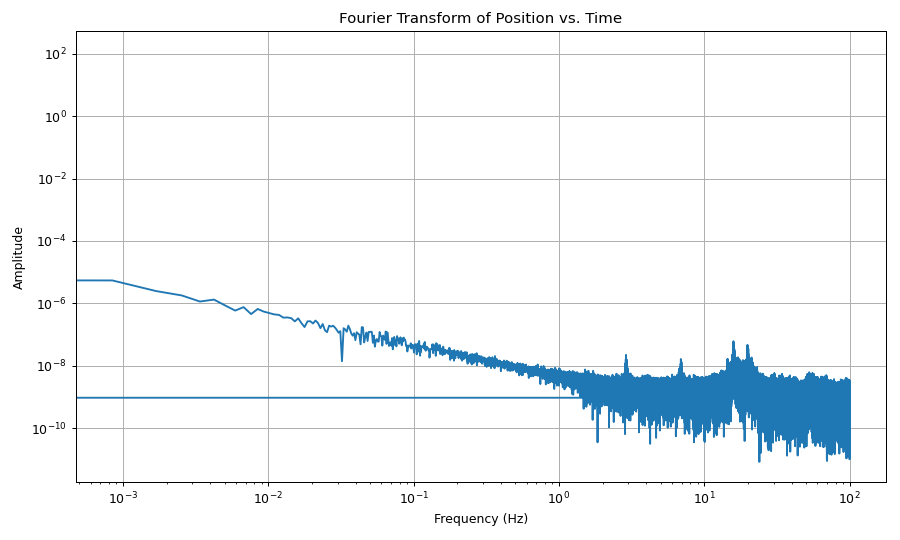

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data from the CSV file
data = pd.read_csv("pos_time_readings.csv")

# Extract Position and create the time vector
position = data["Position (cm)"]
date_time = data["Date"] + " " + data["Time"]
date_time = pd.to_datetime(date_time, format="%Y-%m-%d %H:%M:%S")
time = (date_time - date_time[0]).dt.total_seconds().values  # Convert to seconds

# Compute the Fourier Transform
position_fft = np.fft.fft(position)
position_fft_freq = np.fft.fftfreq(len(time), time[1] - time[0])

# Create the Fourier Transform plot
plt.figure(figsize=(10, 6))
plt.plot(position_fft_freq, 2.0/len(position) * np.abs(position_fft))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xscale('log')
plt.yscale('log')
plt.title("Fourier Transform of Position vs. Time")
plt.grid(True)
# plt.xlim(0, 0.5)  # Display positive frequencies only (up to Nyquist frequency)

plt.tight_layout()
plt.show()

Reads-out the averaging (lowpass) parameter N. The averaging time is calculated by (2^N)*40ns, where N is the averaging value.

In [36]:
averageN = ids.displacement.getAverageN()
averageN

0

In [ ]:
#We can also set the averaging value
value =  # AverageN value from 0 to 24
a = ids.displacement.setAverageN(value)
a


In [39]:
# Get contrast
warningNo, contrast, baseline, mixcontent = ids.adjustment.getContrastInPermille(axis)
print("Contrast:", contrast, "Baseline:", baseline, "Mixcontent:", mixcontent)

Contrast: 881 Baseline: 53 Mixcontent: 881


In [41]:
#Check whether measurement is working
Measurement_check = ids.displacement.getMeasurementEnabled()
Measurement_check

True

##### Pilot Laser Enable/Disable

In [43]:
ids.pilotlaser.disable()
# ids.pilotlaser.enable()

In [44]:
enabled = ids.realtime.AafIsEnabled() #Check anti-aliasing filter is enabled or not
#false: Anti-Aliasing Filter is disabled ; true: Anti-Aliasing Filter is enabled
enabled

True

In [47]:
# Returns the current attenuation at f_nyquist of the anti-aliasing filter = [3-30] dB m f_nyquist
attenuation = ids.realtime.getAafAttenuation()
attenuation

15

In [51]:
# Reads out the HSSL period clock.
period = ids.realtime.getPeriodHsslClk()
period

400

In [53]:
# Reads out the HSSL period gap(No. of Clock)
gap = ids.realtime.getPeriodHsslGap()
gap

1

## Integrate two sensors: IDS + BME680
- Parameters now we have - Date, time, Temperature, Humidity, Pressure, and Position in cm 
- Things need to consider before execution- 1. Measurement reading in IDS

- In the below code, I've used the threading.Thread class to create threads for both arduino_bme680 and Taking_pos_readings functions. The start() method is then called on each thread to begin their execution. The join() method is used to wait for both threads to complete before moving on to the next steps in the program.



Data collection in progress.. Time left: 9 minutes 59 secondsNow logging!
Data collection in progress.. Time left: 9 minutes 58 seconds15/11/2023,13:10:49.790,BME680 test
Data collection in progress Time left: 9 minutes 57 secondsds15/11/2023,13:10:50.454,Temperature,Pressure,RH
Data collection in progress Time left: 9 minutes 57 secondsds15/11/2023,13:10:51.193,24.24,1007.37,41.27
Data collection in progress. Time left: 9 minutes 56 secondss15/11/2023,13:10:52.196,24.12,1007.40,41.04
Data collection in progress Time left: 9 minutes 55 secondsds15/11/2023,13:10:53.200,23.90,1007.40,40.84
Data collection in progress Time left: 9 minutes 54 secondsds15/11/2023,13:10:54.204,23.70,1007.41,40.74
Data collection in progress Time left: 9 minutes 53 secondsds15/11/2023,13:10:55.208,23.54,1007.42,40.70
Data collection in progress Time left: 9 minutes 52 secondsds15/11/2023,13:10:56.212,23.42,1007.42,40.69
Data collection in progress Time left: 9 minutes 51 secondsds15/11/2023,13:10:57.216,23.32

<IPython.core.display.Javascript object>


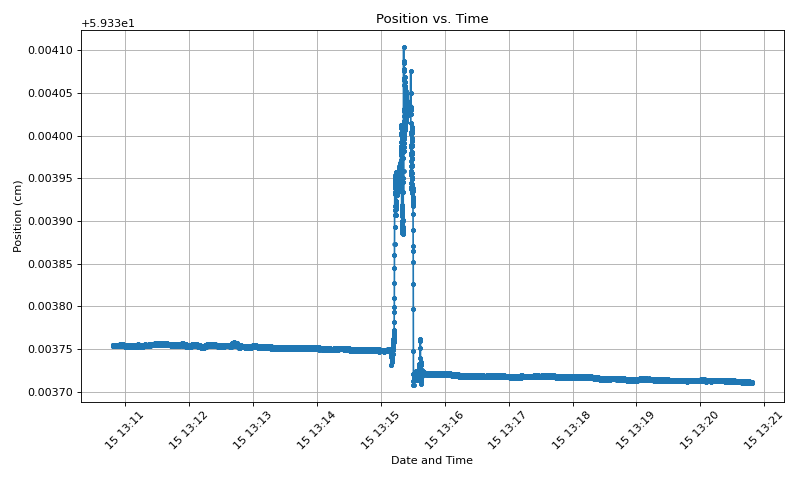

<IPython.core.display.Javascript object>


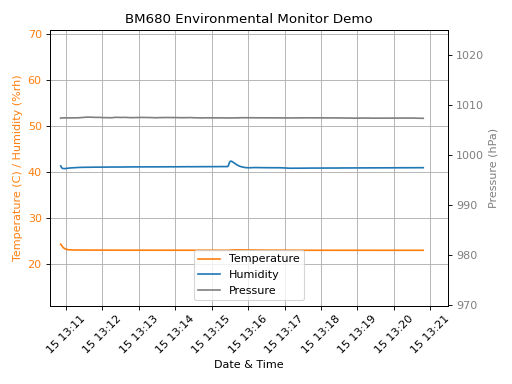

In [27]:
import threading

def job():
    # Set the desired duration in minutes
    duration_minutes = 10  # Change this value to the desired duration

    # Create threads for each function
    thread_arduino = threading.Thread(target=arduino_bme680, args=(duration_minutes,))
    thread_ids = threading.Thread(target=Taking_pos_readings, args=(duration_minutes,))

    # Start the threads
    thread_arduino.start()
    thread_ids.start()

    # Wait for both threads to finish
    thread_arduino.join()
    thread_ids.join()

    # Call the function to modify the CSV file
    # Specify the original and modified file names
    original_filename = "Environmental_Readings.csv"
    modified_filename = "Environmental_Readings_Modified.csv"

    modify_csv(original_filename, modified_filename)
    plot_pos_time()
    Environmental_plot()
  

# Call the job function
job()



In [3]:
plot_pos_time()
Environmental_plot()

NameError: name 'plot_pos_time' is not defined

Data collection in progress. Time left: 29 minutes 59 secondssNow logging!
Data collection in progress.. Time left: 29 minutes 58 seconds15/11/2023,13:59:04.874,BME680 test
Data collection in progress. Time left: 29 minutes 57 secondss15/11/2023,13:59:05.538,Temperature,Pressure,RH
Data collection in progress. Time left: 29 minutes 57 secondss15/11/2023,13:59:06.276,24.08,1007.52,41.58
Data collection in progress Time left: 29 minutes 56 secondsds15/11/2023,13:59:07.280,23.95,1007.55,41.35
Data collection in progress.. Time left: 29 minutes 55 seconds15/11/2023,13:59:08.284,23.73,1007.55,41.15
Data collection in progress.. Time left: 29 minutes 54 seconds15/11/2023,13:59:09.287,23.54,1007.56,41.06
Data collection in progress Time left: 29 minutes 53 secondsds15/11/2023,13:59:10.292,23.38,1007.55,41.02
Data collection in progress Time left: 29 minutes 52 secondsds15/11/2023,13:59:11.295,23.26,1007.55,41.00
Data collection in progress.. Time left: 29 minutes 51 seconds15/11/2023,13:59:12

<IPython.core.display.Javascript object>


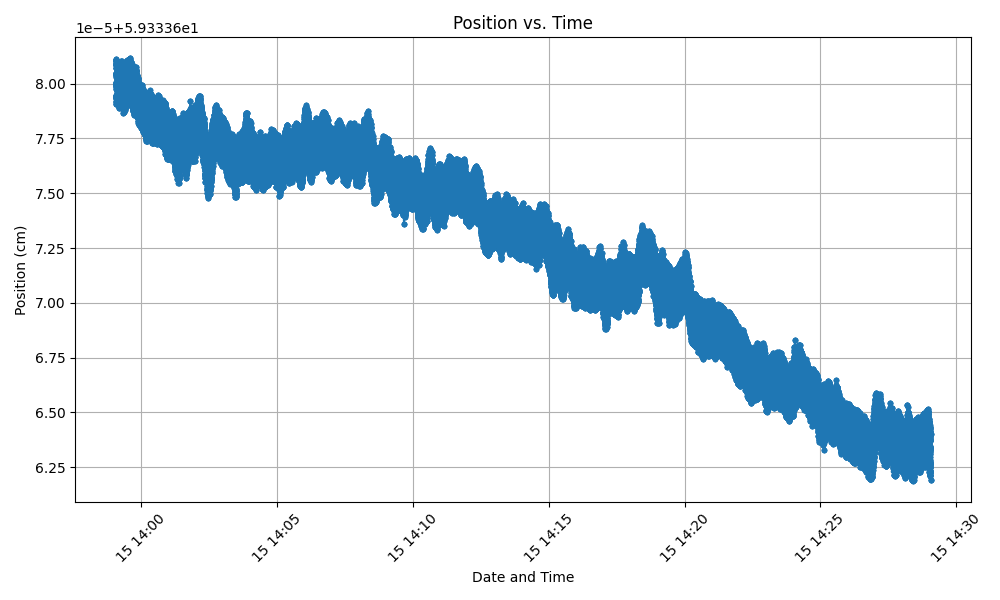

<IPython.core.display.Javascript object>


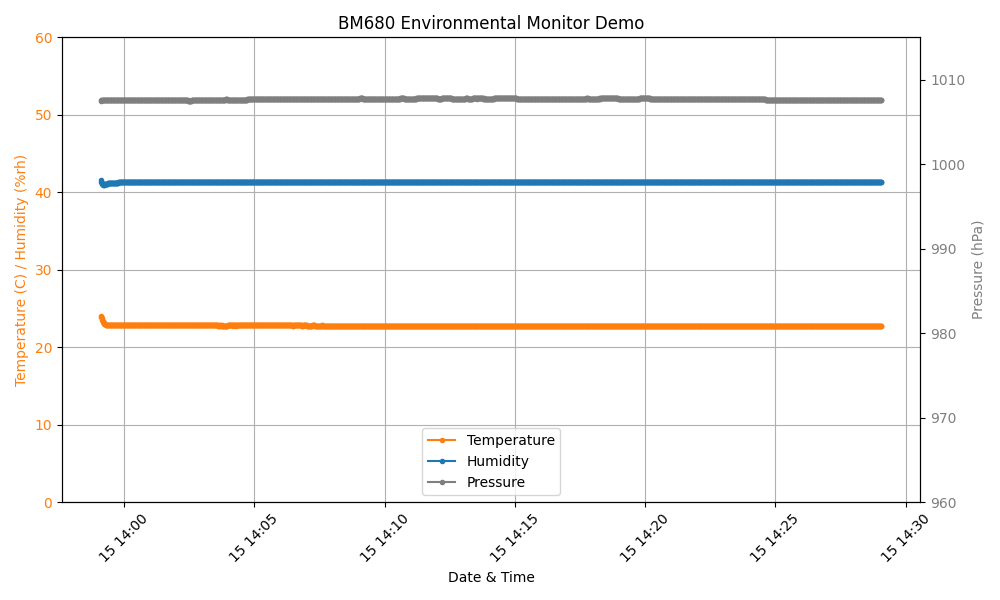

In [63]:
import threading

def job():
    # Set the desired duration in minutes
    duration_minutes = 30  # Change this value to the desired duration

    # Create threads for each function
    thread_arduino = threading.Thread(target=arduino_bme680, args=(duration_minutes,))
    thread_ids = threading.Thread(target=Taking_pos_readings, args=(duration_minutes,))

    # Start the threads
    thread_arduino.start()
    thread_ids.start()

    # Wait for both threads to finish
    thread_arduino.join()
    thread_ids.join()

    # Call the function to modify the CSV file
    # Specify the original and modified file names
    original_filename = "Environmental_Readings.csv"
    modified_filename = "Environmental_Readings_Modified.csv"
    modify_csv(original_filename, modified_filename)
    
    plot_pos_time()
    Environmental_plot()
  

# Call the job function
job()


<IPython.core.display.Javascript object>


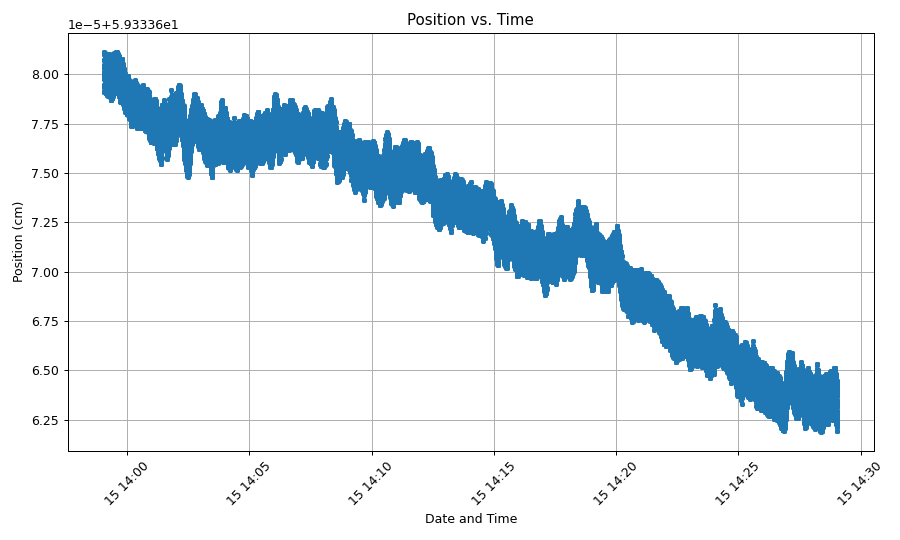

<IPython.core.display.Javascript object>


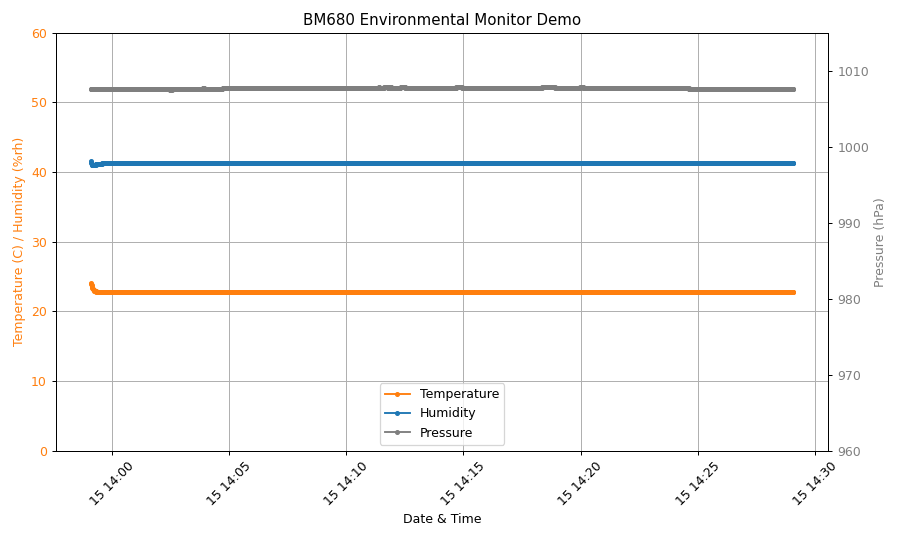

In [66]:
plot_pos_time()
Environmental_plot()

In [102]:
mean_pressure = data['Position (cm)'].mean()
mean_pressure


58.96145435299126

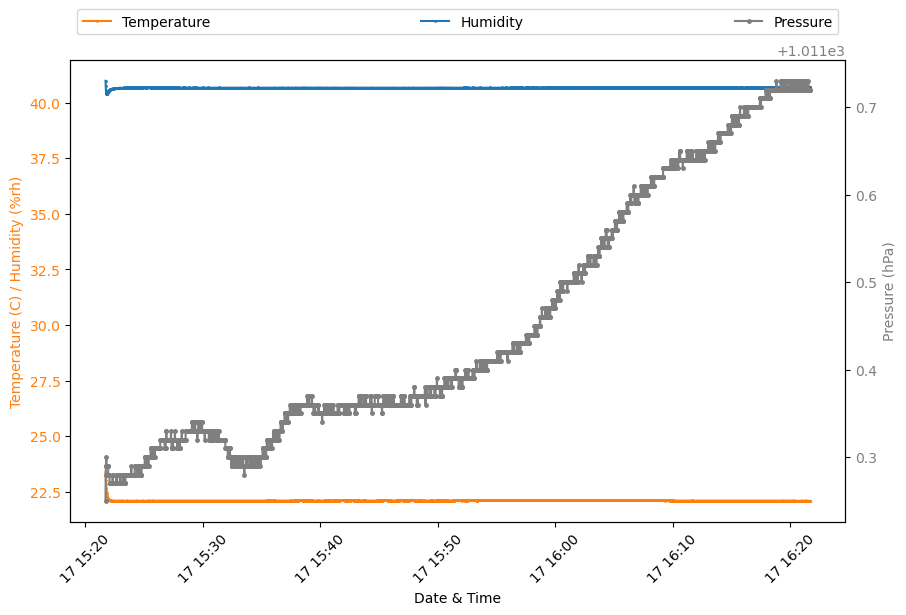

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Environmental_Readings_Modified_job2.csv', parse_dates=[['Date', 'Time']], dayfirst=True)

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Temperature and Humidity on the left y-axis
color = 'tab:orange'
ax1.set_xlabel('Date & Time')
ax1.set_ylabel('Temperature (C) / Humidity (%rh)', color=color)
ax1.plot(df['Date_Time'], df['Temperature(C)'], label='Temperature', marker='.', linestyle='-',markersize = 2, color=color)
ax1.plot(df['Date_Time'], df['Humidity(%rh)'], label='Humidity',  marker='.', linestyle='-', markersize = 2, color='tab:blue')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Pressure on the right
ax2 = ax1.twinx()
color = 'tab:grey'
ax2.set_ylabel('Pressure (hPa)', color=color)
ax2.plot(df['Date_Time'], df['Pressure(hPa)'], label='Pressure',  marker='.', linestyle='-',markersize = 5, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the legends at the bottom
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0,1.04,1, 0.2), loc ="lower left", mode = "expand",ncol = 3)

ax1.tick_params(axis='x', labelrotation = 45)
# fig.suptitle('Zoomed Out version')
# Show the plot
plt.show()



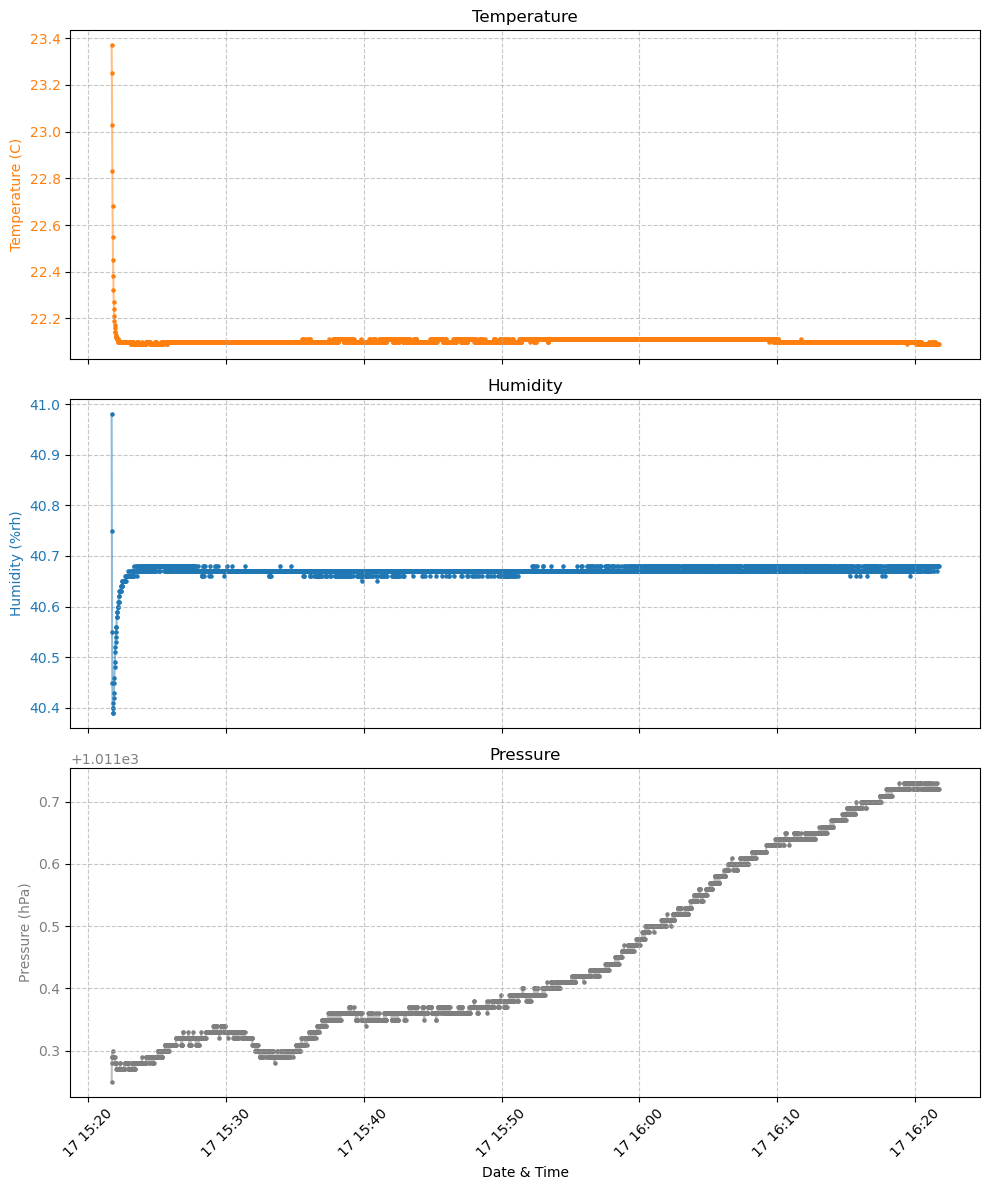

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Environmental_Readings_Modified_job2.csv', parse_dates=[['Date', 'Time']], dayfirst=True)

# Create subplots with shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot Temperature on the first subplot
ax1.set_ylabel('Temperature (C)', color='tab:orange')
ax1.scatter(df['Date_Time'], df['Temperature(C)'], color='tab:orange', label='Temperature', s=5)
ax1.plot(df['Date_Time'], df['Temperature(C)'], linestyle='-', color='tab:orange', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Temperature')

# Plot Humidity on the second subplot
ax2.set_ylabel('Humidity (%rh)', color='tab:blue')
ax2.scatter(df['Date_Time'], df['Humidity(%rh)'], color='tab:blue', label='Humidity', s=5)
ax2.plot(df['Date_Time'], df['Humidity(%rh)'], linestyle='-', color='tab:blue', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_title('Humidity')

# Plot Pressure on the third subplot
ax3.set_xlabel('Date & Time')
ax3.set_ylabel('Pressure (hPa)', color='tab:grey')
ax3.scatter(df['Date_Time'], df['Pressure(hPa)'], color='tab:grey', label='Pressure', s=5)
ax3.plot(df['Date_Time'], df['Pressure(hPa)'], linestyle='-', color='tab:grey', alpha=0.5)
ax3.tick_params(axis='y', labelcolor='tab:grey')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_title('Pressure')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


In [107]:
# Calculate mean pressure
mean_pressure = df['Pressure(hPa)'].mean()
mean_pressure


1011.4530878661308

<IPython.core.display.Javascript object>


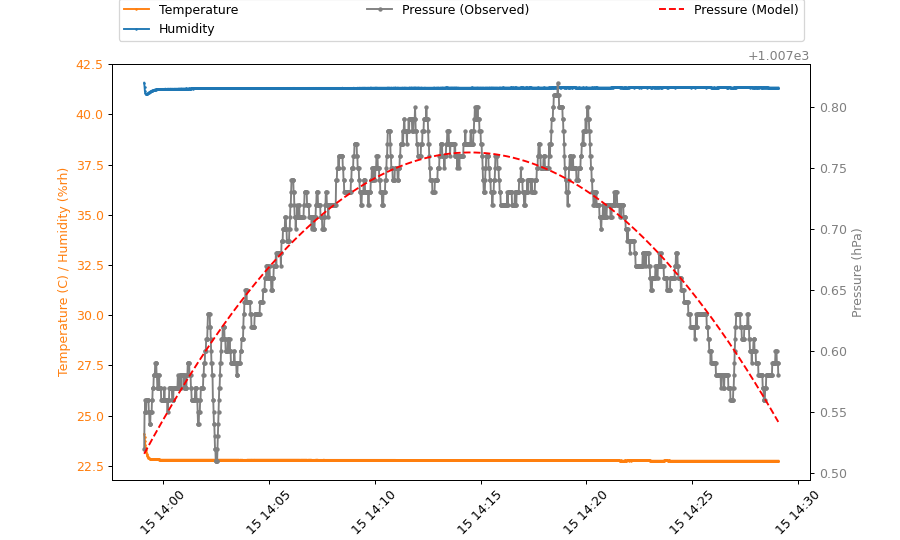

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Environmental_Readings_Modified.csv', parse_dates=[['Date', 'Time']], dayfirst=True)

# Create a quadratic model for pressure
X = np.arange(len(df)).reshape(-1, 1)
y = df['Pressure(hPa)']

# Fit a quadratic regression model
model = LinearRegression()
X_squared = np.column_stack((X, X**2))
model.fit(X_squared, y)

# Predict pressure values using the quadratic model
df['Pressure_Model'] = model.predict(X_squared)

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Temperature and Humidity on the left y-axis
color = 'tab:orange'
ax1.set_xlabel('Date & Time')
ax1.set_ylabel('Temperature (C) / Humidity (%rh)', color=color)
ax1.plot(df['Date_Time'], df['Temperature(C)'], label='Temperature', marker='.', linestyle='-',markersize = 2, color=color)
ax1.plot(df['Date_Time'], df['Humidity(%rh)'], label='Humidity',  marker='.', linestyle='-', markersize = 2, color='tab:blue')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Pressure on the right
ax2 = ax1.twinx()
color = 'tab:grey'
ax2.set_ylabel('Pressure (hPa)', color=color)
ax2.plot(df['Date_Time'], df['Pressure(hPa)'], label='Pressure (Observed)',  marker='.', linestyle='-',markersize = 5, color=color)
ax2.plot(df['Date_Time'], df['Pressure_Model'], label='Pressure (Model)', linestyle='--', color='red')
ax2.tick_params(axis='y', labelcolor=color)

# Show the legends at the bottom
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0,1.04,1, 0.2), loc ="lower left", mode = "expand",ncol = 3)

ax1.tick_params(axis='x', labelrotation = 45)

# Show the plot
plt.show()


In [ ]:
#start

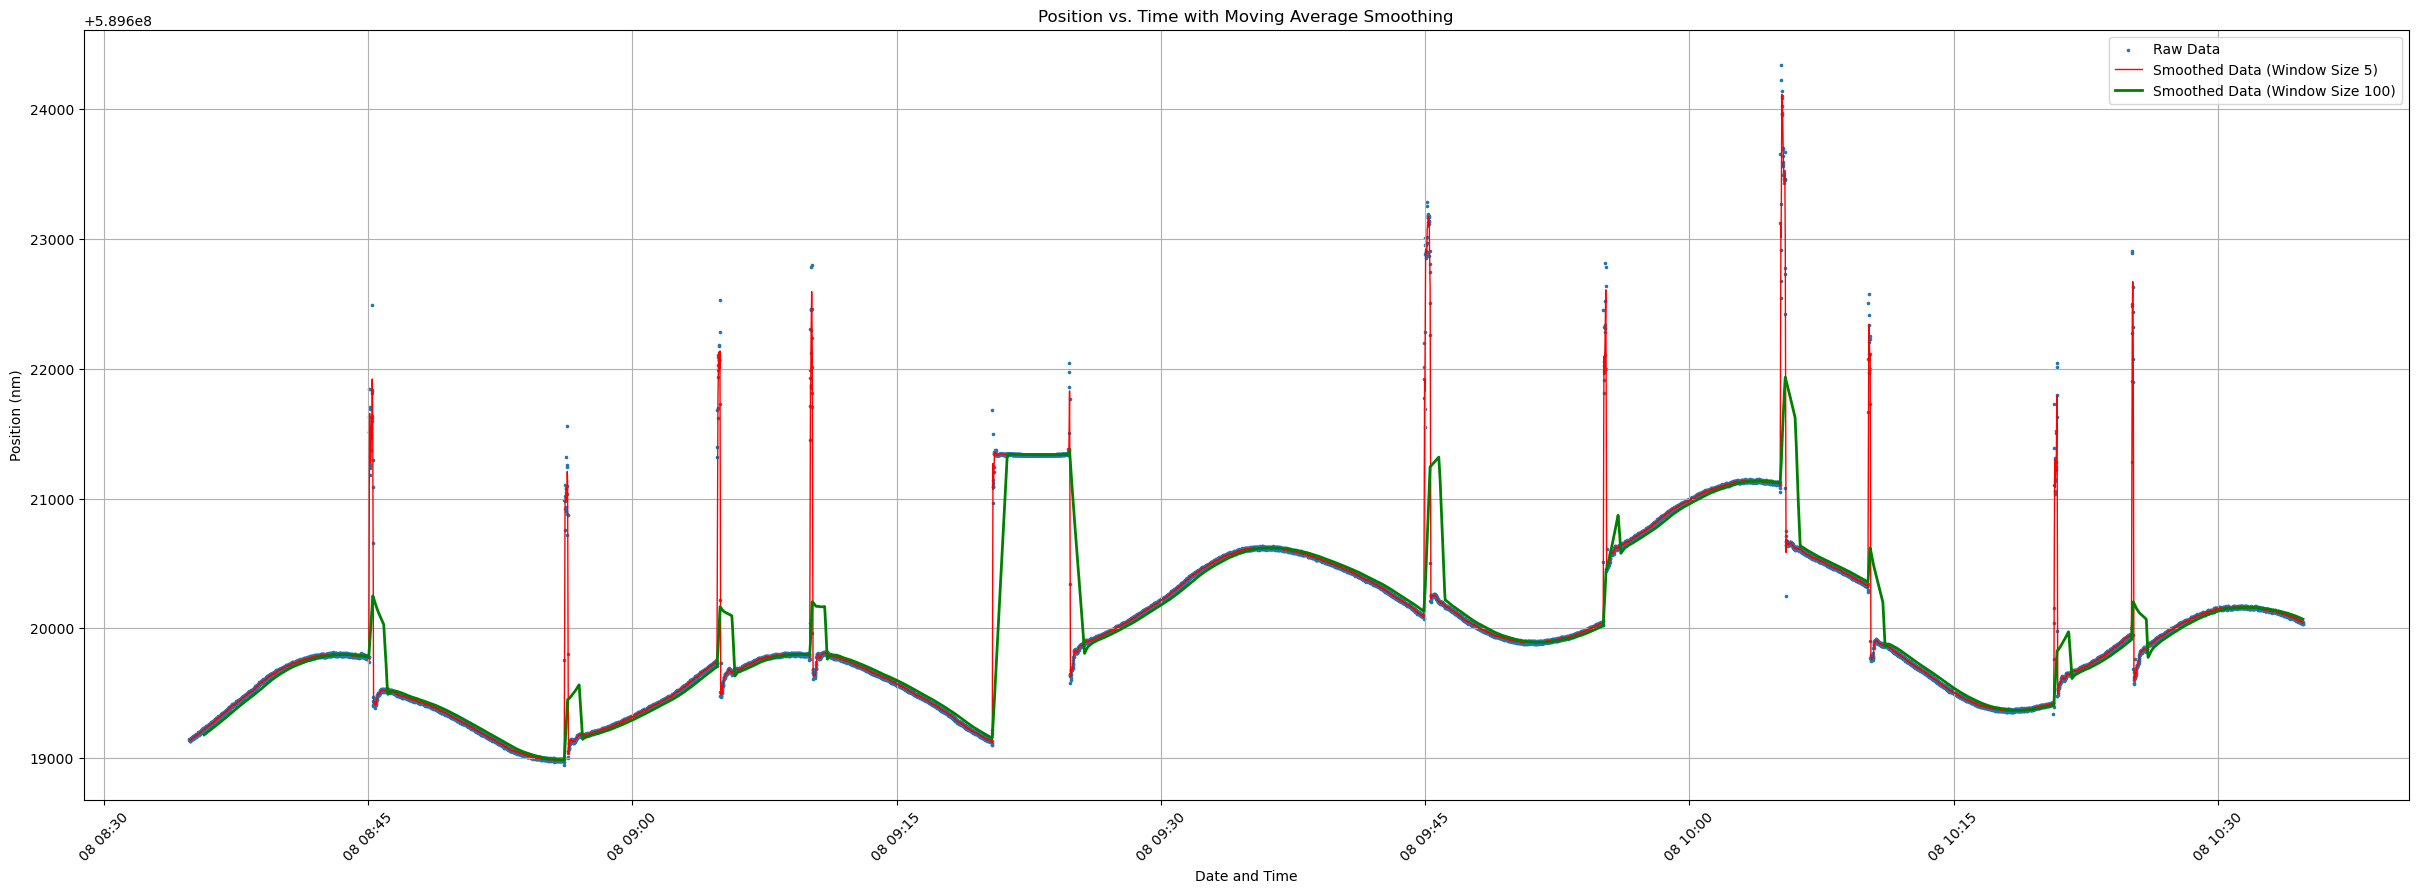

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv("pos_time_readings_slid_experiment.csv")

# Extract Date, Time, and Position columns
date_time = data["Date"] + " " + data["Time"]
position_cm = data["Position (cm)"]

# Convert position to nanometers
position_nm = position_cm * 1e7  # 1 cm = 1e7 nm

# Convert date and time to datetime objects
date_time = pd.to_datetime(date_time, format="%Y-%m-%d %H:%M:%S")

# Apply a moving average filter
window_size = 5  # Adjust the window size as needed
window_size1 = 100
position_smoothed = position_nm.rolling(window=window_size).mean()
position_smoothed1 = position_nm.rolling(window=window_size1).mean()

# Create the scatter plot
plt.figure(figsize=(30, 10))
plt.scatter(date_time, position_nm, marker='.', s=10, label="Raw Data")  # Original data
plt.plot(date_time, position_smoothed, label=f"Smoothed Data (Window Size {window_size})", linestyle='-', linewidth=1, color='red')
plt.plot(date_time, position_smoothed1, label=f"Smoothed Data (Window Size {window_size1})", linestyle='-', linewidth=2, color='green')

plt.xlabel("Date and Time")
plt.ylabel("Position (nm)")
plt.title("Position vs. Time with Moving Average Smoothing")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig("smoothed_plot.png")

# Display the plot in a separate window in Jupyter Notebook
plt.show()


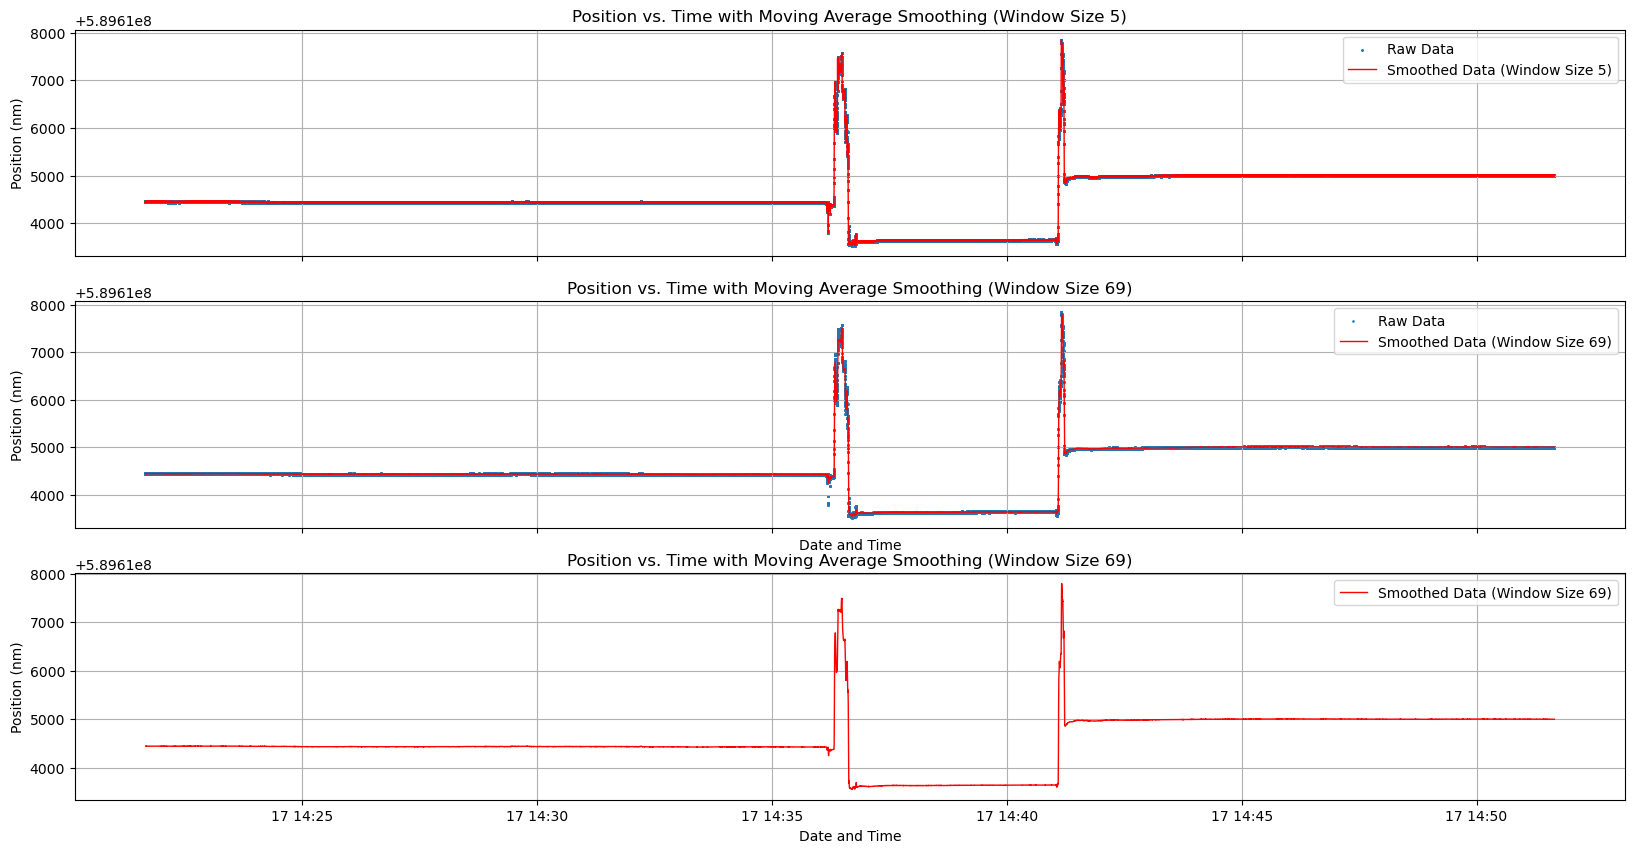

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv("pos_time_readings_job1i.csv")

# Extract Date, Time, and Position columns
date_time = data["Date"] + " " + data["Time"]
position_cm = data["Position (cm)"]

# Convert position to nanometers
position_nm = position_cm * 1e7  # 1 cm = 1e7 nm

# Convert date and time to datetime objects
date_time = pd.to_datetime(date_time, format="%Y-%m-%d %H:%M:%S")

# Apply moving average filters with different window sizes
window_size1 = 5  # Adjust the window size as needed
window_size2 = 69
position_smoothed1 = position_nm.rolling(window=window_size1).mean()
position_smoothed2 = position_nm.rolling(window=window_size2).mean()

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

# Plot for the first window size
ax1.scatter(date_time, position_nm, marker='.', s=5, label="Raw Data")  # Original data
ax1.plot(date_time, position_smoothed1, label=f"Smoothed Data (Window Size {window_size1})", linestyle='-', linewidth=1, color='red')
ax1.set_ylabel("Position (nm)")
ax1.set_title(f"Position vs. Time with Moving Average Smoothing (Window Size {window_size1})")
ax1.legend()
ax1.grid(True)

# Plot for the second window size
ax2.scatter(date_time, position_nm, marker='.', s=3, label="Raw Data")  # Original data
ax2.plot(date_time, position_smoothed2, label=f"Smoothed Data (Window Size {window_size2})", linestyle='-', linewidth=1, color='red')
ax2.set_xlabel("Date and Time")
ax2.set_ylabel("Position (nm)")
ax2.set_title(f"Position vs. Time with Moving Average Smoothing (Window Size {window_size2})")
ax2.legend()
ax2.grid(True)

# Plot for the Third window size
# ax3.scatter(date_time, position_nm, marker='.', s=3, label="Raw Data")  # Original data
ax3.plot(date_time, position_smoothed2, label=f"Smoothed Data (Window Size {window_size2})", linestyle='-', linewidth=1, color='red')
ax3.set_xlabel("Date and Time")
ax3.set_ylabel("Position (nm)")
ax3.set_title(f"Position vs. Time with Moving Average Smoothing (Window Size {window_size2})")
ax3.legend()
ax3.grid(True)

# Save the plot as an image
plt.savefig("smoothed_subplot_slid.png")

# Display the plot in a separate window in Jupyter Notebook
plt.show()


The sampling rate is determined by the frequency at which data points are collected or recorded. In the context of moving average filter with a window size of 100, the effective sampling rate is influenced by the number of data points considered within the window.

Sensor is providing roughly 69 data values every 1 second, and using a moving average window size of 100, the effective sampling rate can be calculated as follows:

Effective Sampling Rate = Number of Data Points/Window Size

Substitute the given values:

Effective Sampling Rate} = 69/100 = 0.69Hz

So, with a window size of 100 and 69 data values per second, the effective sampling rate for moving average filter is approximately 0.69 Hz. This means that, in the context of the moving average window, you are effectively considering data points at a rate of 0.69 Hz.

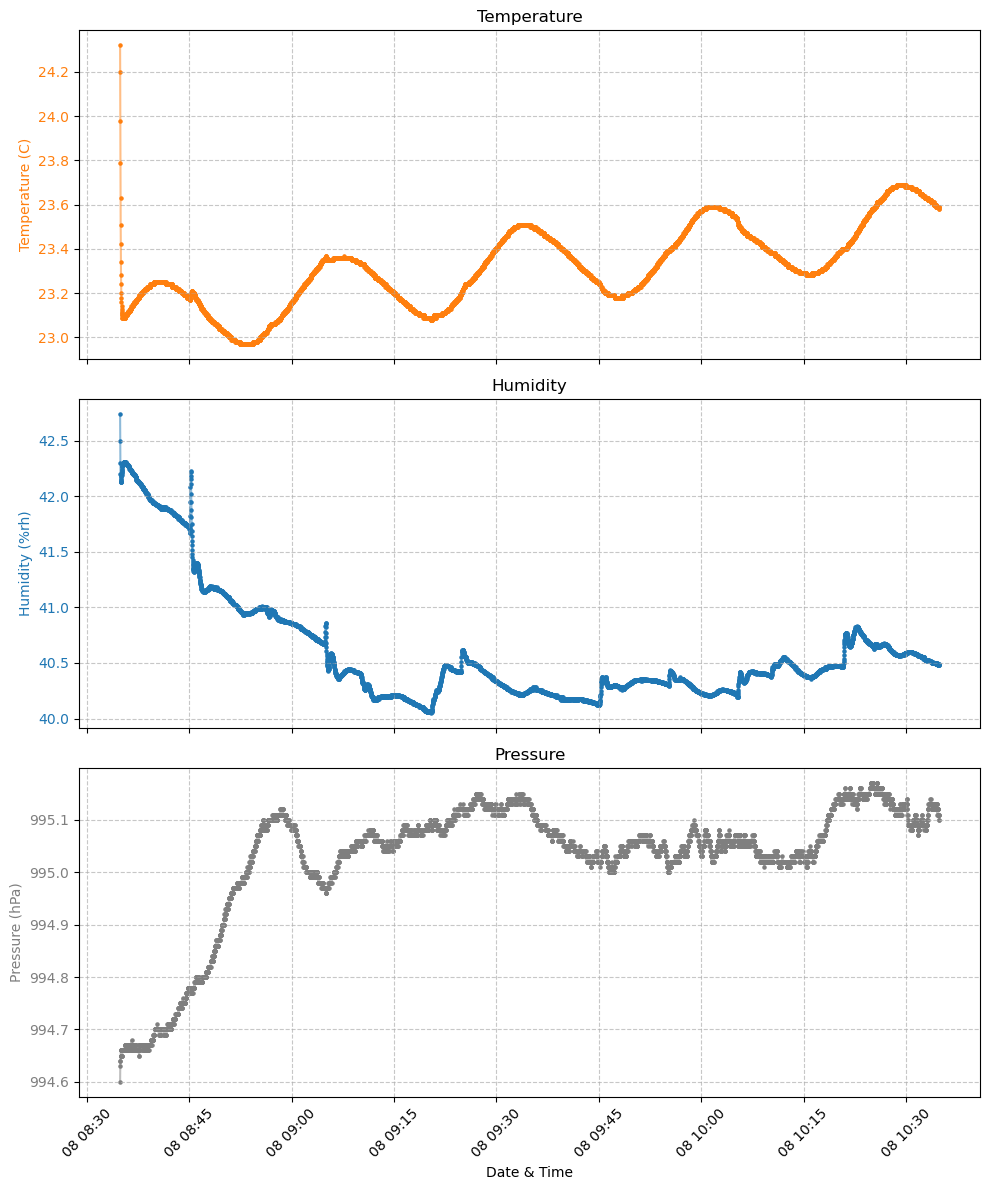

In [8]:

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Environmental_Readings_slid_experiment_Modified.csv', parse_dates=[['Date', 'Time']], dayfirst=True)

# Create subplots with shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Set y-axis limits
# temperature_limits = (22.7, 22.9)
# humidity_limits = (40.3, 40.8)
# pressure_limits = (1011.2, 1011.8)

# Plot Temperature on the first subplot
ax1.set_ylabel('Temperature (C)', color='tab:orange')
ax1.scatter(df['Date_Time'], df['Temperature(C)'], color='tab:orange', label='Temperature', s=5)
ax1.plot(df['Date_Time'], df['Temperature(C)'], linestyle='-', color='tab:orange', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Temperature')
# ax1.set_ylim(temperature_limits)  # Set y-axis limits for Temperature


# Plot Humidity on the second subplot
ax2.set_ylabel('Humidity (%rh)', color='tab:blue')
ax2.scatter(df['Date_Time'], df['Humidity(%rh)'], color='tab:blue', label='Humidity', s=5)
ax2.plot(df['Date_Time'], df['Humidity(%rh)'], linestyle='-', color='tab:blue', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_title('Humidity')
# ax2.set_ylim(humidity_limits)  # Set y-axis limits for Humidity


# Plot Pressure on the third subplot
ax3.set_xlabel('Date & Time')
ax3.set_ylabel('Pressure (hPa)', color='tab:grey')
ax3.scatter(df['Date_Time'], df['Pressure(hPa)'], color='tab:grey', label='Pressure', s=5)
ax3.plot(df['Date_Time'], df['Pressure(hPa)'], linestyle='-', color='tab:grey', alpha=0.5)
ax3.tick_params(axis='y', labelcolor='tab:grey')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_title('Pressure')
# ax3.set_ylim(pressure_limits)  # Set y-axis limits for Pressure

plt.savefig('experiment4_slid12')
# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
#end

In [ ]:
#for smoothning

<IPython.core.display.Javascript object>


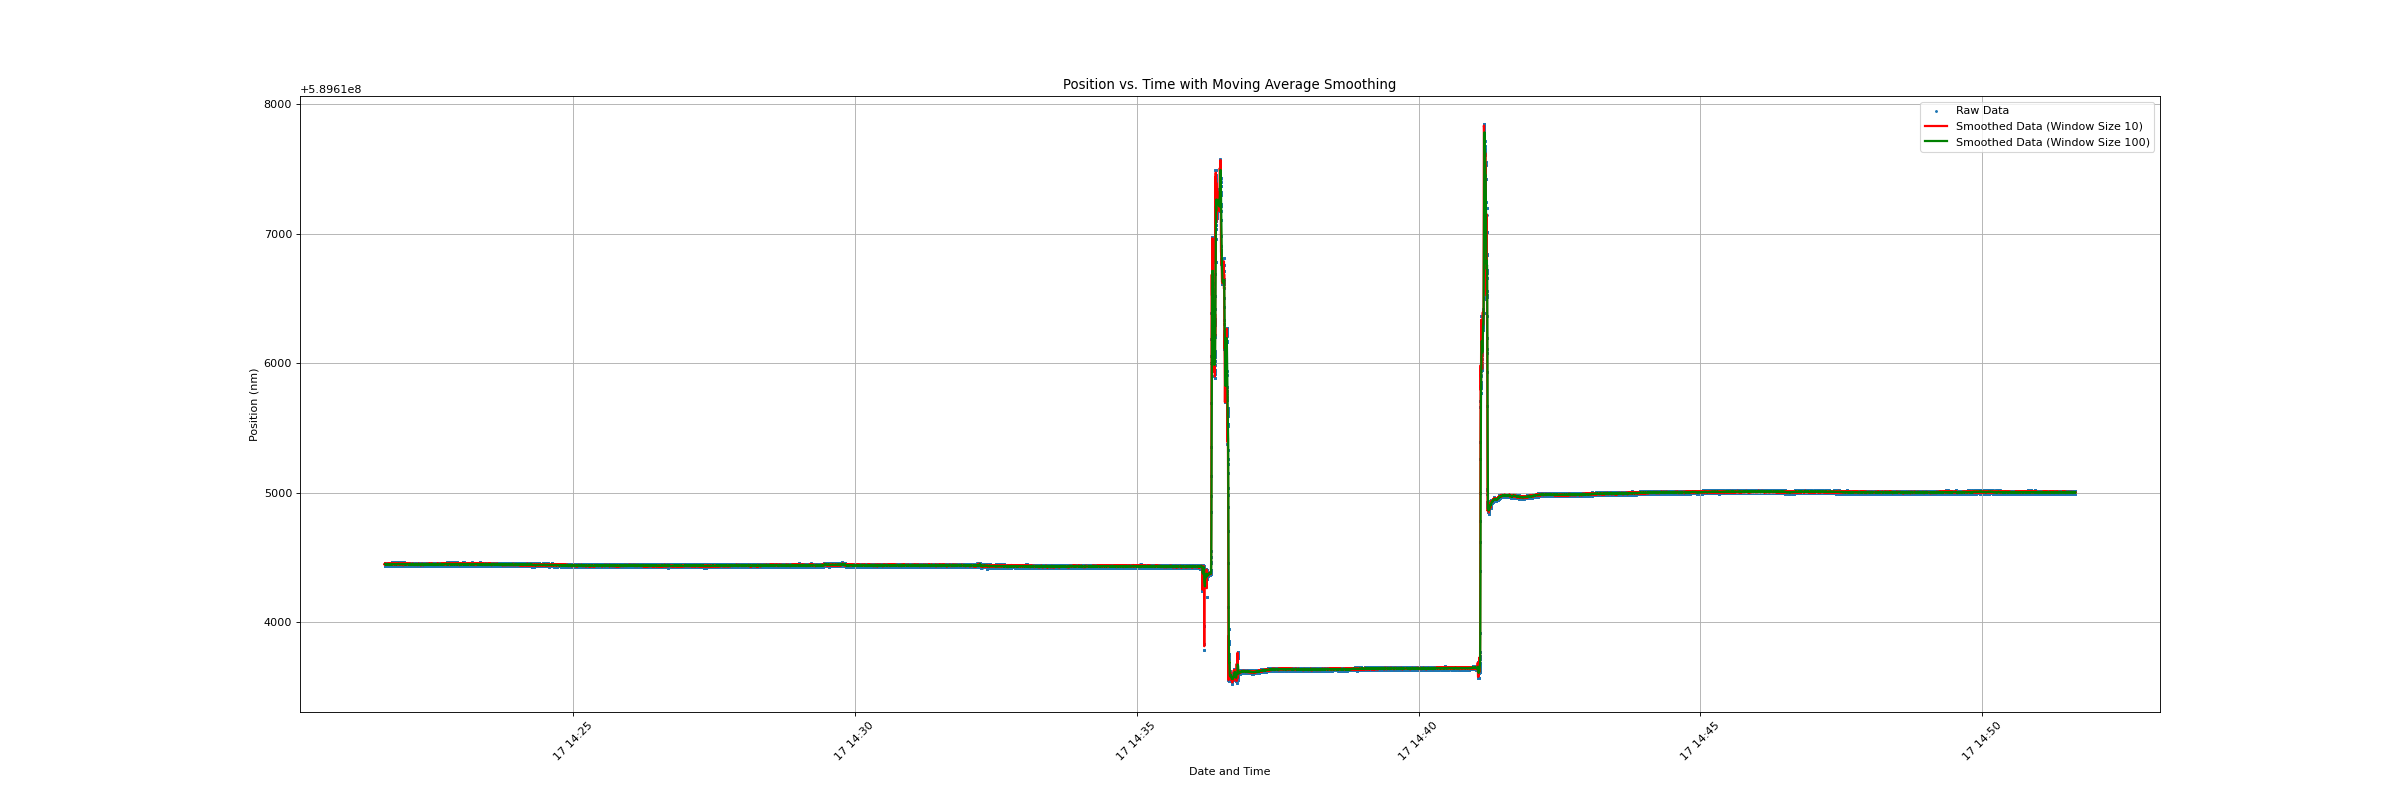

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv("po i.csv")

# Extract Date, Time, and Position columns
date_time = data["Date"] + " " + data["Time"]
position_cm = data["Position (cm)"]

# Convert position to nanometers
position_nm = position_cm * 1e7  # 1 cm = 1e7 nm

# Convert date and time to datetime objects
date_time = pd.to_datetime(date_time, format="%Y-%m-%d %H:%M:%S")

# Apply a moving average filter
window_size = 10  # Adjust the window size as needed
window_size1 = 100
position_smoothed = position_nm.rolling(window=window_size).mean()
position_smoothed1 = position_nm.rolling(window=window_size1).mean()

# Create the scatter plot
plt.figure(figsize=(30, 10))
plt.scatter(date_time, position_nm, marker='.', s=10, label="Raw Data")  # Original data
plt.plot(date_time, position_smoothed, label=f"Smoothed Data (Window Size {window_size})", linestyle='-', linewidth=2, color='red')
plt.plot(date_time, position_smoothed1, label=f"Smoothed Data (Window Size {window_size1})", linestyle='-', linewidth=2, color='green')

plt.xlabel("Date and Time")
plt.ylabel("Position (nm)")
plt.title("Position vs. Time with Moving Average Smoothing")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig("smoothed_plot.png")

# Display the plot in a separate window in Jupyter Notebook
plt.show()


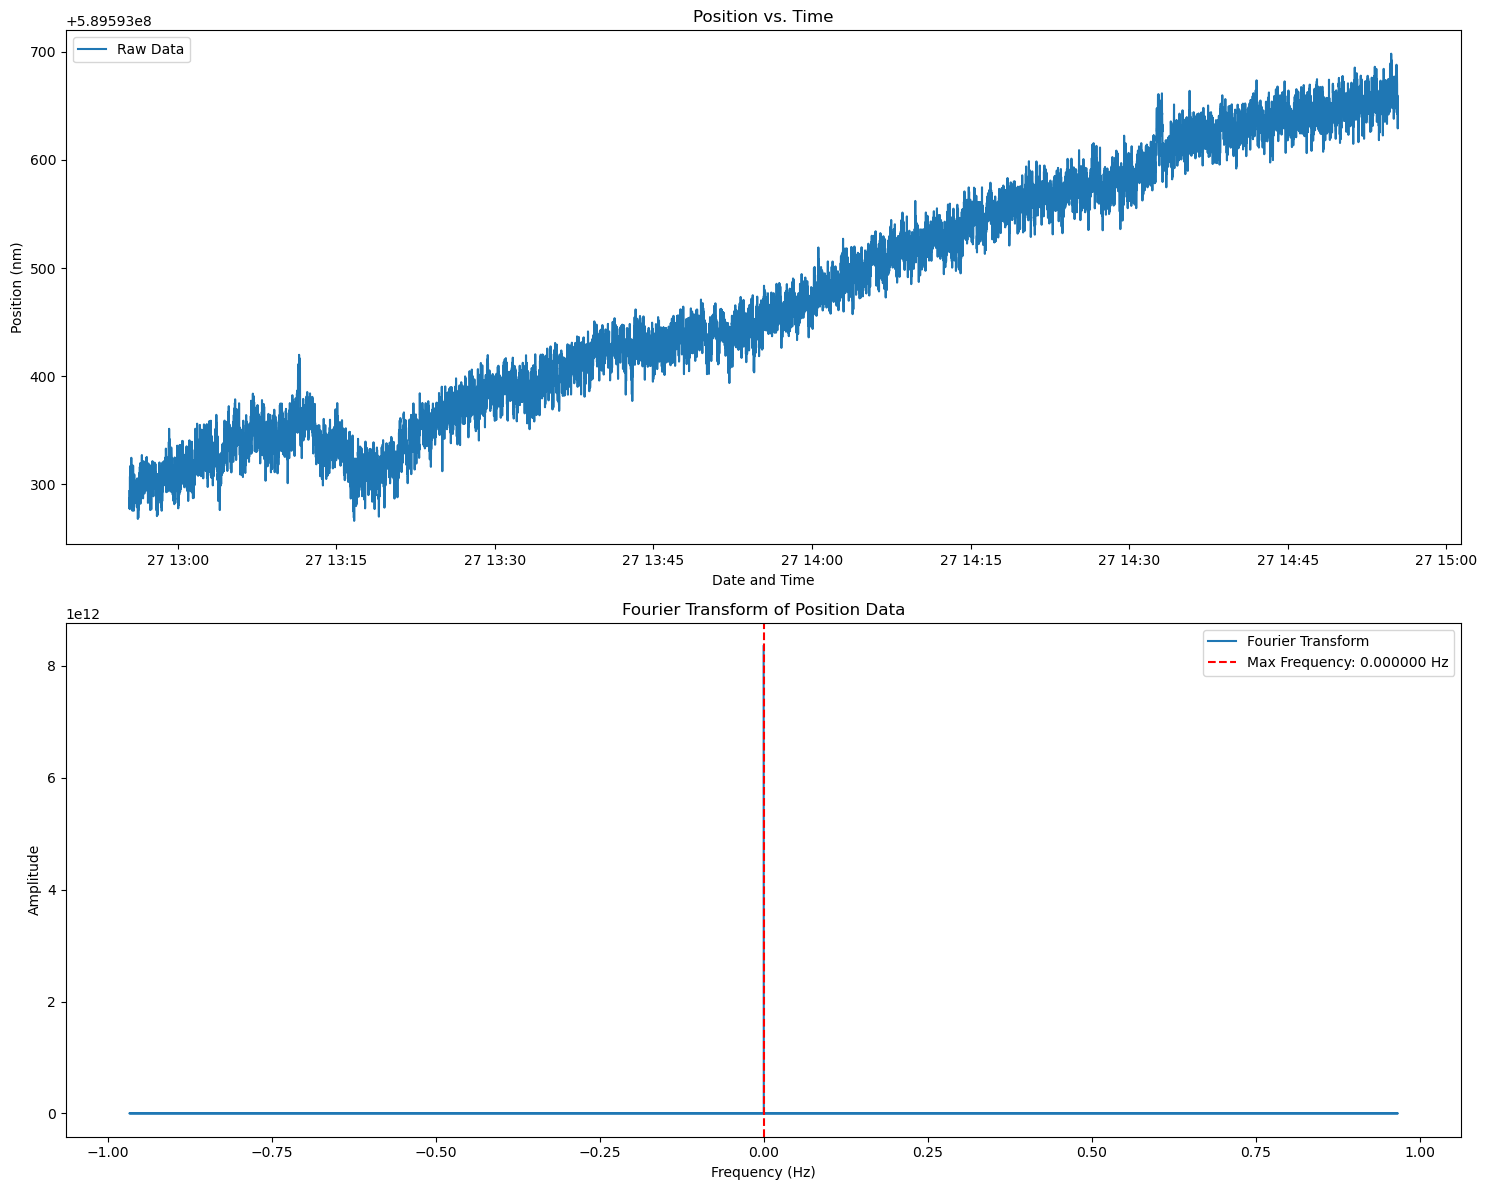

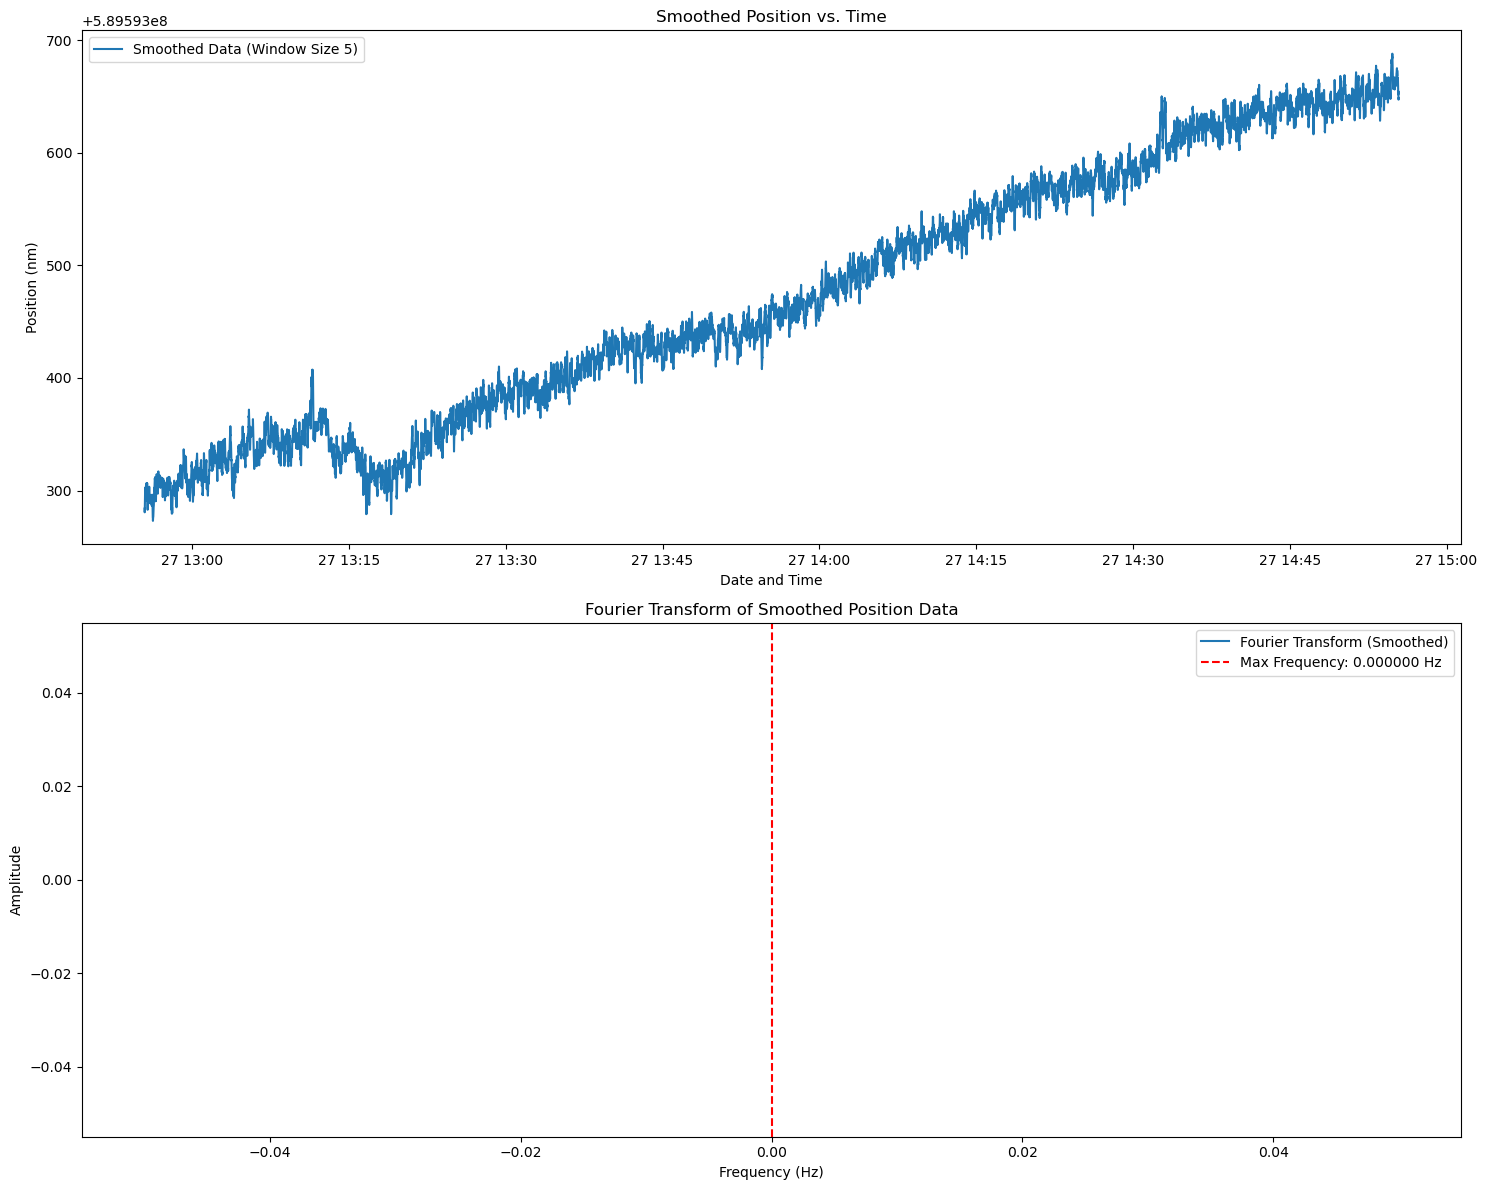

In [26]:
import numpy as np
import scipy.fft
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv("pos_time_readings_exp3.csv")

# Extract Date, Time, and Position columns
date_time = data["Date"] + " " + data["Time"]
position_cm = data["Position (cm)"]

# Convert position to nanometers
position_nm = position_cm * 1e7  # 1 cm = 1e7 nm

# Convert date and time to datetime objects
date_time = pd.to_datetime(date_time, format="%Y-%m-%d %H:%M:%S")

# Apply a moving average filter
window_size = 5  # Adjust the window size as needed
position_smoothed = position_nm.rolling(window=window_size).mean()

# Perform Fourier Transform on the raw position data
position_fft = np.fft.fft(position_nm)
position_fft_freq = np.fft.fftfreq(len(position_nm), d=(date_time[1] - date_time[0]).total_seconds())

# Perform Fourier Transform on the smoothed position data
smoothed_fft = np.fft.fft(position_smoothed)
smoothed_fft_freq = np.fft.fftfreq(len(position_smoothed), d=(date_time[1] - date_time[0]).total_seconds())

# Find the index corresponding to the maximum amplitude
position_max_index = np.argmax(np.abs(position_fft))
smoothed_max_index = np.argmax(np.abs(smoothed_fft))

# Get the corresponding frequency values
position_max_freq = np.abs(position_fft_freq[position_max_index])
smoothed_max_freq = np.abs(smoothed_fft_freq[smoothed_max_index])

# Create the plots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot raw position data and its Fourier Transform
axes[0].plot(date_time, position_nm, label="Raw Data")
axes[0].set_xlabel("Date and Time")
axes[0].set_ylabel("Position (nm)")
axes[0].set_title("Position vs. Time")
axes[0].legend()

axes[1].plot(position_fft_freq, np.abs(position_fft), label="Fourier Transform")
axes[1].axvline(x=position_max_freq, color='r', linestyle='--', label=f"Max Frequency: {position_max_freq:.6f} Hz")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Fourier Transform of Position Data")
axes[1].legend()

plt.tight_layout()
plt.show()

# Create the plots for smoothed data
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot smoothed position data and its Fourier Transform
axes[0].plot(date_time, position_smoothed, label=f"Smoothed Data (Window Size {window_size})")
axes[0].set_xlabel("Date and Time")
axes[0].set_ylabel("Position (nm)")
axes[0].set_title("Smoothed Position vs. Time")
axes[0].legend()

axes[1].plot(smoothed_fft_freq, np.abs(smoothed_fft), label="Fourier Transform (Smoothed)")
axes[1].axvline(x=smoothed_max_freq, color='r', linestyle='--', label=f"Max Frequency: {smoothed_max_freq:.6f} Hz")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Fourier Transform of Smoothed Position Data")
axes[1].legend()

plt.tight_layout()
plt.show()


In [46]:
mean_position = np.mean(position)
std_position = np.std(position)
print("Mean Position:", mean_position, "cm")
print("Standard Deviation of Position:", std_position,"cm")


Mean Position: 58.96148009231045 cm
Standard Deviation of Position: 3.542539235728769e-06 cm


<IPython.core.display.Javascript object>


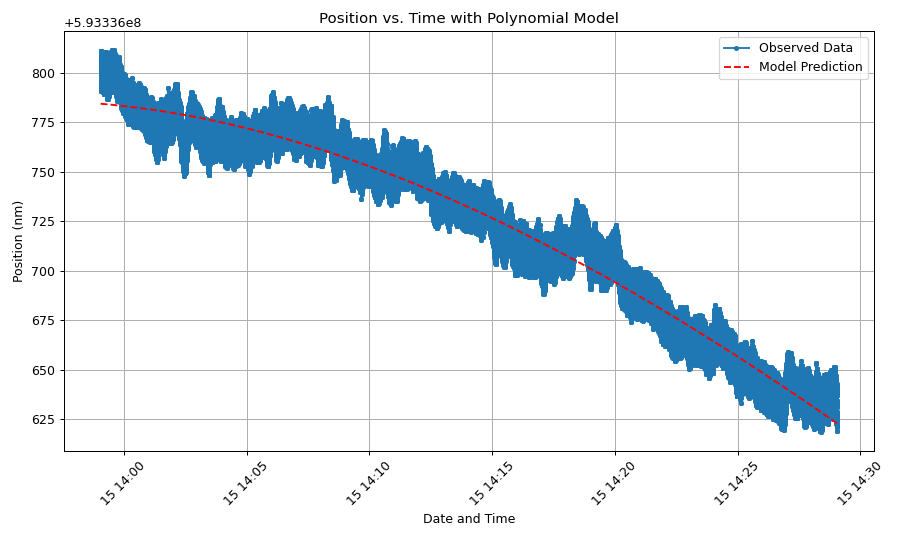

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Load data from the CSV file
data = pd.read_csv("pos_time_readings.csv")

# Extract Date, Time, and Position columns
date_time = data["Date"] + " " + data["Time"]
position_cm = data["Position (cm)"]

# Convert position to nanometers
position_nm = position_cm * 1e7  # 1 cm = 1e7 nm

# Convert date and time to datetime objects
date_time = pd.to_datetime(date_time, format="%Y-%m-%d %H:%M:%S")

# Create a polynomial model for position (degree=2 for quadratic, degree=3 for cubic)
X = np.arange(len(data)).reshape(-1, 1)
y = position_nm

# Polynomial features
poly = PolynomialFeatures(degree=3)  # Change degree as needed
X_poly = poly.fit_transform(X)

# Fit a polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict position values using the polynomial model
data['Position_Model'] = model.predict(X_poly)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(date_time, position_nm, marker='.', linestyle='-', label='Observed Data')
plt.plot(date_time, data['Position_Model'], linestyle='--', color='red', label='Model Prediction')
plt.xlabel("Date and Time")
plt.ylabel("Position (nm)")
plt.title("Position vs. Time with Polynomial Model")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Code to take data from outer box 

In [13]:
from datetime import datetime
def arduino_bme680(duration_minutes):
    start_time = time.time()

    # Set the filename
    fn = "Outer_Box_120mins.csv"
    
    try:
        f = open(fn, "w")

        # Set the COM port
        cp = "COM13"
        
        try:
            ser = serial.Serial(cp, 9600)
        except:
            print(f"Could not open {cp}! Check if the port is available and try again.")
            return

        print("Now logging!")

        try:
            while (time.time() - start_time) < duration_minutes * 60:
                s = ser.readline()
                timestamp = datetime.now().strftime("%d/%m/%Y,%H:%M:%S.%f")[:-3]  # Get timestamp with milliseconds
                print(timestamp + "," + s.decode()[:-1])
                f.write(timestamp + "," + s.decode()[:-1])
        except KeyboardInterrupt:
            print("Logging Aborted, closing file!")
        finally:
            f.close()
            ser.close()
    except Exception as e:
        print(f"Error: {e}")

arduino_bme680(91)


Now logging!
29/11/2023,14:14:23.225,BME680 test
29/11/2023,14:14:23.886,Temperature,Pressure,RH
29/11/2023,14:14:24.622,24.08,994.64,42.42
29/11/2023,14:14:25.622,23.96,994.67,42.17
29/11/2023,14:14:26.631,23.74,994.68,41.96
29/11/2023,14:14:27.631,23.56,994.68,41.85
29/11/2023,14:14:28.647,23.41,994.69,41.80
29/11/2023,14:14:29.642,23.29,994.69,41.76
29/11/2023,14:14:30.647,23.19,994.69,41.73
29/11/2023,14:14:31.655,23.12,994.69,41.72
29/11/2023,14:14:32.661,23.07,994.69,41.70
29/11/2023,14:14:33.660,23.02,994.69,41.67
29/11/2023,14:14:34.669,22.99,994.69,41.64
29/11/2023,14:14:35.664,22.96,994.69,41.61
29/11/2023,14:14:36.675,22.94,994.69,41.59
29/11/2023,14:14:37.675,22.93,994.69,41.56
29/11/2023,14:14:38.682,22.92,994.69,41.54
29/11/2023,14:14:39.685,22.91,994.69,41.53
29/11/2023,14:14:40.690,22.90,994.70,41.52
29/11/2023,14:14:41.687,22.90,994.70,41.51
29/11/2023,14:14:42.695,22.89,994.70,41.50
29/11/2023,14:14:43.701,22.89,994.70,41.49
29/11/2023,14:14:44.698,22.89,994.69,41.49


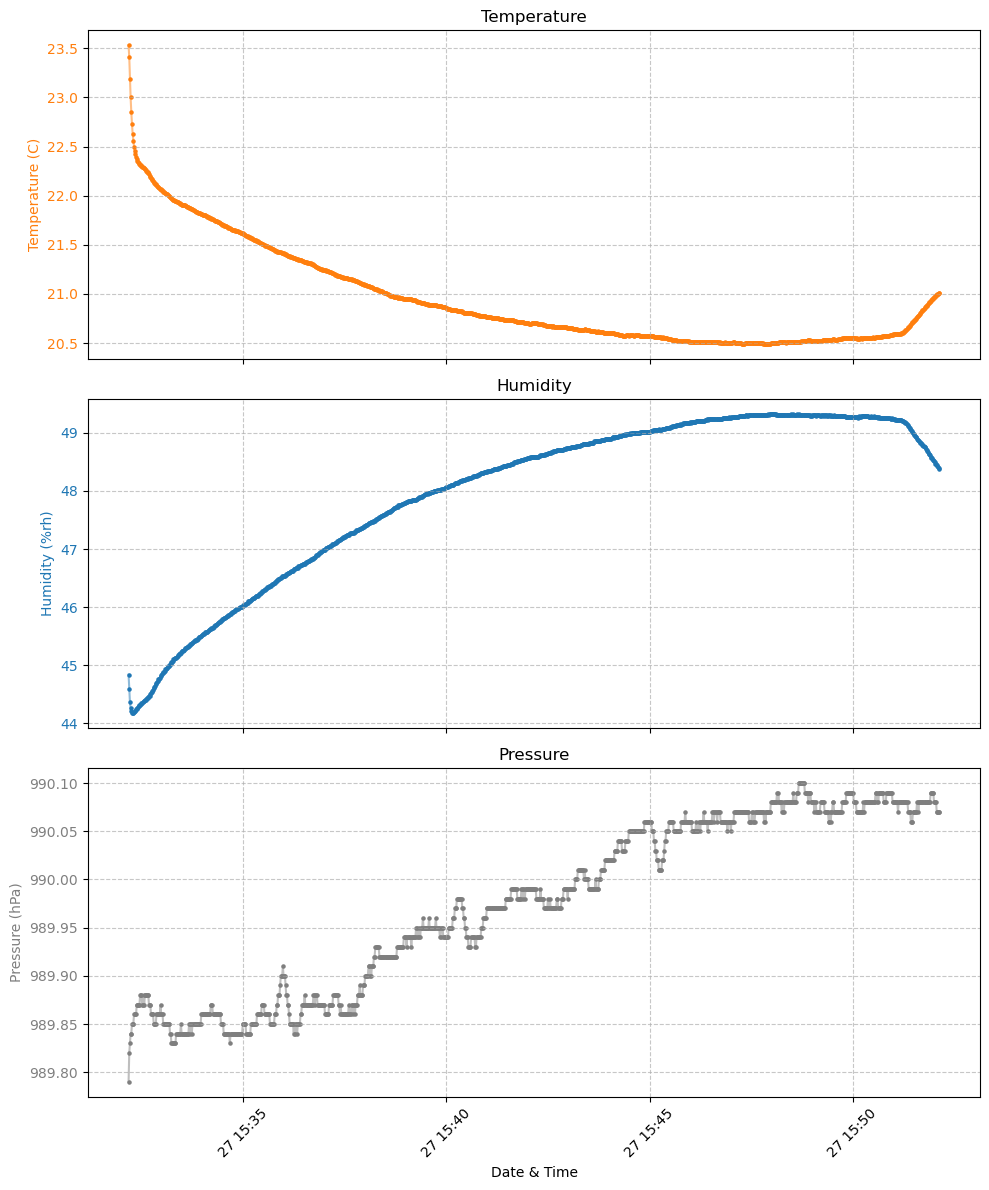

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Outer_Box_20mins_Modified.csv', parse_dates=[['Date', 'Time']], dayfirst=True)

# Create subplots with shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot Temperature on the first subplot
ax1.set_ylabel('Temperature (C)', color='tab:orange')
ax1.scatter(df['Date_Time'], df['Temperature(C)'], color='tab:orange', label='Temperature', s=5)
ax1.plot(df['Date_Time'], df['Temperature(C)'], linestyle='-', color='tab:orange', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Temperature')

# Plot Humidity on the second subplot
ax2.set_ylabel('Humidity (%rh)', color='tab:blue')
ax2.scatter(df['Date_Time'], df['Humidity(%rh)'], color='tab:blue', label='Humidity', s=5)
ax2.plot(df['Date_Time'], df['Humidity(%rh)'], linestyle='-', color='tab:blue', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_title('Humidity')

# Plot Pressure on the third subplot
ax3.set_xlabel('Date & Time')
ax3.set_ylabel('Pressure (hPa)', color='tab:grey')
ax3.scatter(df['Date_Time'], df['Pressure(hPa)'], color='tab:grey', label='Pressure', s=5)
ax3.plot(df['Date_Time'], df['Pressure(hPa)'], linestyle='-', color='tab:grey', alpha=0.5)
ax3.tick_params(axis='y', labelcolor='tab:grey')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_title('Pressure')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
 # Specify the original and modified file names
original_filename = "Outer_Box_90mins.csv"
modified_filename = "Outer_Box_90mins_Modified.csv"
modify_csv(original_filename, modified_filename)

Error: name 'csv' is not defined


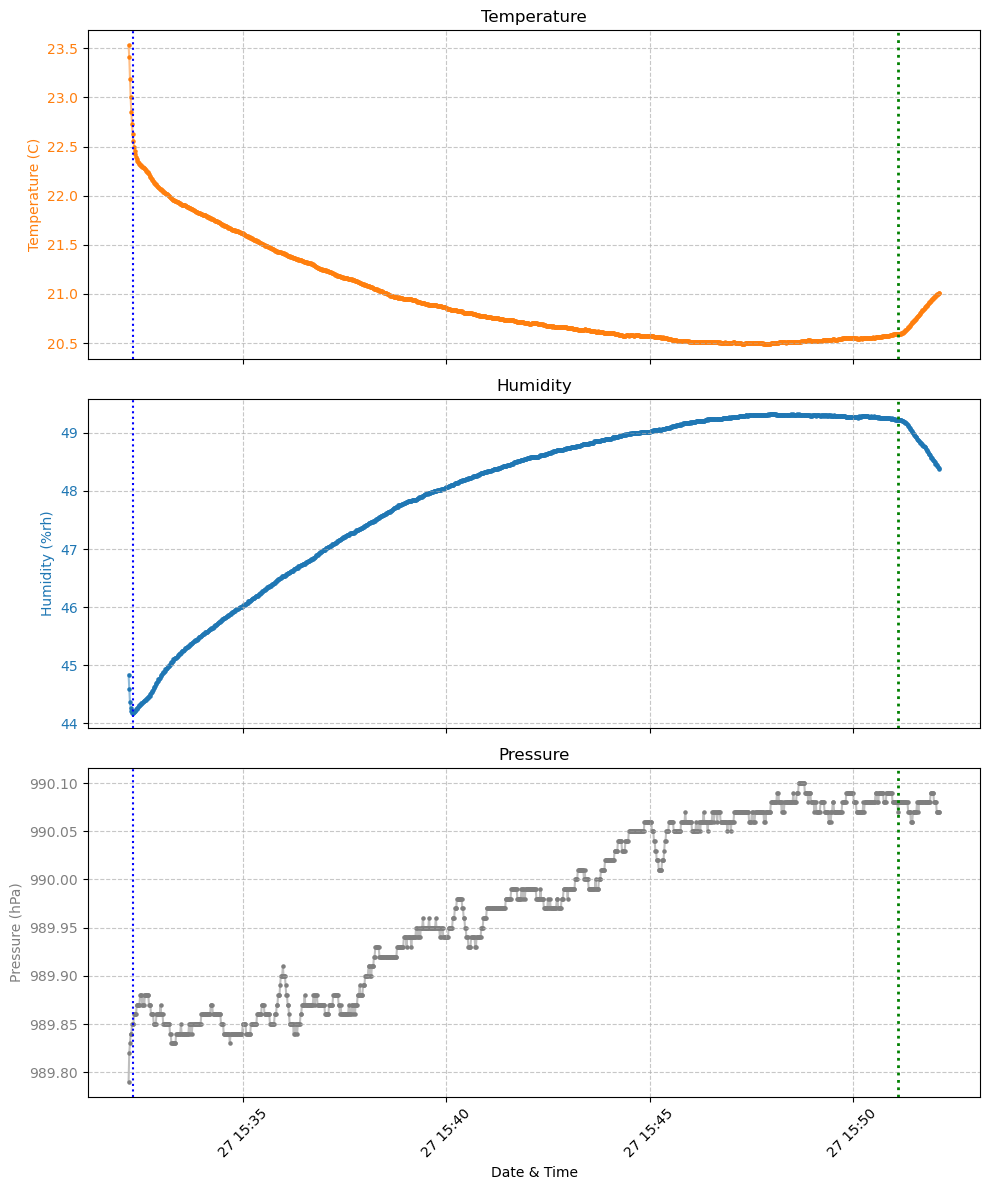

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Outer_Box_20mins_Modified.csv', parse_dates=[['Date', 'Time']], dayfirst=True)

# Convert the specific date and time to pandas Timestamps
vertical_line_time1 = pd.to_datetime('27/11/2023 15:32:17.681', dayfirst=True)
vertical_line_time2 = pd.to_datetime('27/11/2023 15:51:06.978', dayfirst=True)

# Create subplots with shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot Temperature on the first subplot
ax1.set_ylabel('Temperature (C)', color='tab:orange')
ax1.scatter(df['Date_Time'], df['Temperature(C)'], color='tab:orange', label='Temperature', s=5)
ax1.plot(df['Date_Time'], df['Temperature(C)'], linestyle='-', color='tab:orange', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Temperature')

# Plot Humidity on the second subplot
ax2.set_ylabel('Humidity (%rh)', color='tab:blue')
ax2.scatter(df['Date_Time'], df['Humidity(%rh)'], color='tab:blue', label='Humidity', s=5)
ax2.plot(df['Date_Time'], df['Humidity(%rh)'], linestyle='-', color='tab:blue', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_title('Humidity')

# Plot Pressure on the third subplot
ax3.set_xlabel('Date & Time')
ax3.set_ylabel('Pressure (hPa)', color='tab:grey')
ax3.scatter(df['Date_Time'], df['Pressure(hPa)'], color='tab:grey', label='Pressure', s=5)
ax3.plot(df['Date_Time'], df['Pressure(hPa)'], linestyle='-', color='tab:grey', alpha=0.5)
ax3.tick_params(axis='y', labelcolor='tab:grey')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_title('Pressure')

# Plotting vertical lines at the specified dates and times
ax1.axvline(vertical_line_time1, color='b', linestyle=':', linewidth=1.5, label='Line 1')
ax1.axvline(vertical_line_time2, color='g', linestyle=':', linewidth=2, label='Line 2')
ax2.axvline(vertical_line_time1, color='b', linestyle=':', linewidth=1.5)
ax2.axvline(vertical_line_time2, color='g', linestyle=':', linewidth=2)
ax3.axvline(vertical_line_time1, color='b', linestyle=':', linewidth=1.5)
ax3.axvline(vertical_line_time2, color='g', linestyle=':', linewidth=2)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

plt.savefig("Outerbox_20mins_with_lines.png")

# Show the plot
plt.show()


# Refractive Index Correction

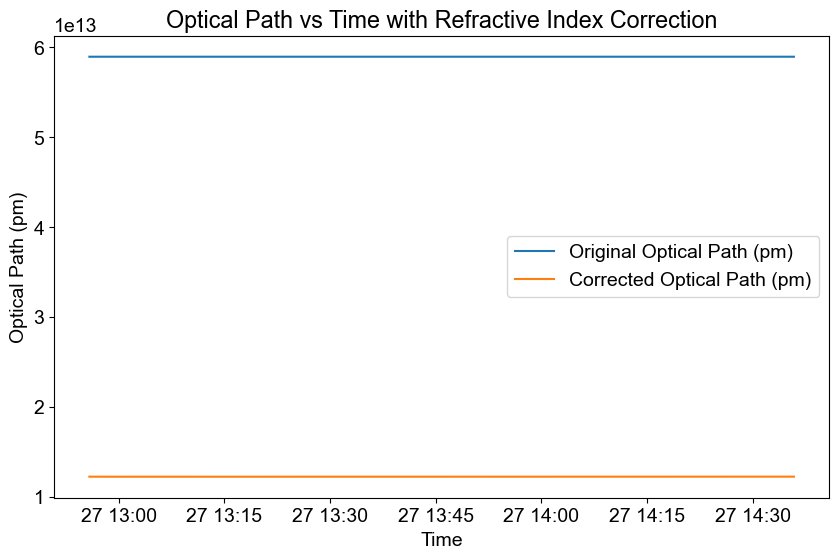

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Read optical path data
optical_path_data = pd.read_csv('pos_time_readings_exp3.csv', parse_dates={'Timestamp': ['Date', 'Time']})

# Read temperature, pressure, humidity data
sensor_data = pd.read_csv('Environmental_Readings_Modified_exp3.csv', parse_dates={'Timestamp': ['Date', 'Time']})

# Assuming you have the refractive index correction function defined
def calculate_refractive_index_correction(temperature, pressure, humidity):
    # Replace this function with your specific refractive index correction equation
    # A sample linear equation is used here for demonstration purposes
    A = 0.1
    B = 0.01
    C = 0.001
    return (A * temperature + B * pressure + C * humidity) * 1e12  # Convert to picometers

# Merge the two dataframes on the timestamp
merged_data = pd.merge(optical_path_data, sensor_data, on='Timestamp')

# Calculate the corrected optical path in picometers
merged_data['Corrected_Position_pm'] = (merged_data['Position (cm)'] +
                                        calculate_refractive_index_correction(
                                            merged_data['Temperature(C)'],
                                            merged_data['Pressure(hPa)'],
                                            merged_data['Humidity(%rh)']
                                        ))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Timestamp'], merged_data['Position (cm)'] * 1e12, label='Original Optical Path (pm)')
plt.plot(merged_data['Timestamp'], merged_data['Corrected_Position_pm'], label='Corrected Optical Path (pm)')
plt.xlabel('Time')
plt.ylabel('Optical Path (pm)')
plt.title('Optical Path vs Time with Refractive Index Correction')
plt.legend()
plt.show()


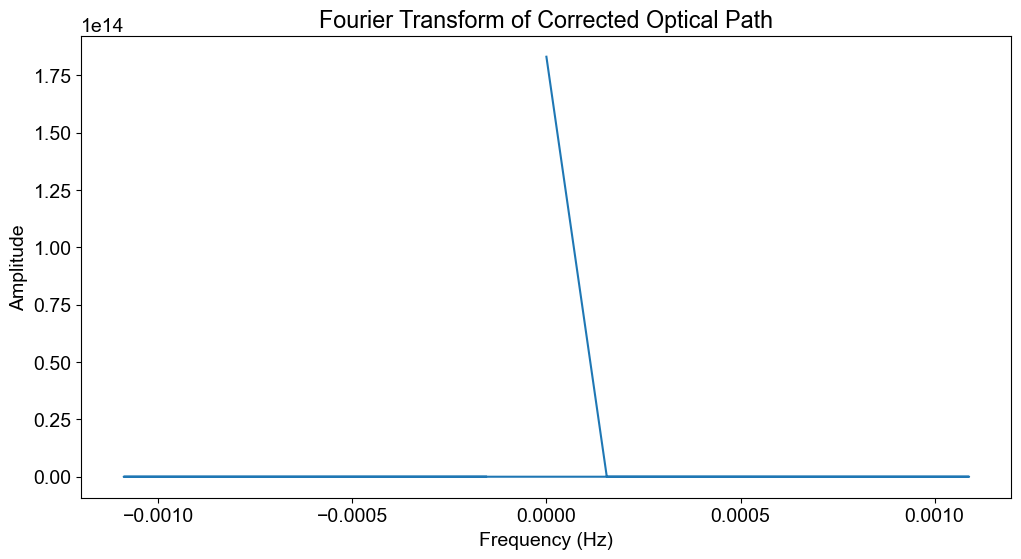

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read optical path data
optical_path_data = pd.read_csv('pos_time_readings_exp3.csv', parse_dates={'Timestamp': ['Date', 'Time']})

# Read temperature, pressure, humidity data
sensor_data = pd.read_csv('Environmental_Readings_Modified_exp3.csv', parse_dates={'Timestamp': ['Date', 'Time']})

# Assuming you have the refractive index correction function defined
def calculate_refractive_index_correction(temperature, pressure, humidity):
    # Replace this function with your specific refractive index correction equation
    # A sample linear equation is used here for demonstration purposes
    A = 0.1
    B = 0.01
    C = 0.001
    return (A * temperature + B * pressure + C * humidity) * 1e12  # Convert to picometers

# Merge the two dataframes on the timestamp
merged_data = pd.merge(optical_path_data, sensor_data, on='Timestamp')

# Calculate the corrected optical path in picometers
merged_data['Corrected_Position_pm'] = (merged_data['Position (cm)'] +
                                        calculate_refractive_index_correction(
                                            merged_data['Temperature(C)'],
                                            merged_data['Pressure(hPa)'],
                                            merged_data['Humidity(%rh)']
                                        ))

# Perform Fourier Transform
time_series = merged_data['Timestamp'].values.astype(np.int64) // 10**9  # Convert to seconds
optical_path_signal = merged_data['Corrected_Position_pm'].values

# Calculate the FFT
fft_result = np.fft.fft(optical_path_signal)
freq = np.fft.fftfreq(len(fft_result), d=np.mean(np.diff(time_series)))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(freq, np.abs(fft_result))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Corrected Optical Path')
plt.show()


In [17]:
def calculate_refractive_index_correction(temperature, pressure, humidity):
    # Coefficients for the linear equation (adjust as needed)
    A = 1.5e-5  # Example coefficient for temperature
    B = 2.0e-7  # Example coefficient for pressure
    C = 1.0e-6  # Example coefficient for humidity
    
    # Constants for the linear equation (adjust as needed)
    D = 1.0  # Example constant
    
    # Calculate the refractive index correction in picometers
    correction = A * temperature + B * pressure + C * humidity + D
    return correction * 1e12  # Convert to picometers

# Example usage
temperature = 25.0  # in Celsius
pressure = 1000.0  # in hPa
humidity = 50.0  # in percentage

refractive_index_correction = calculate_refractive_index_correction(temperature, pressure, humidity)
print(f'Refractive Index Correction: {refractive_index_correction} picometers')


Refractive Index Correction: 1000625000000.0001 picometers


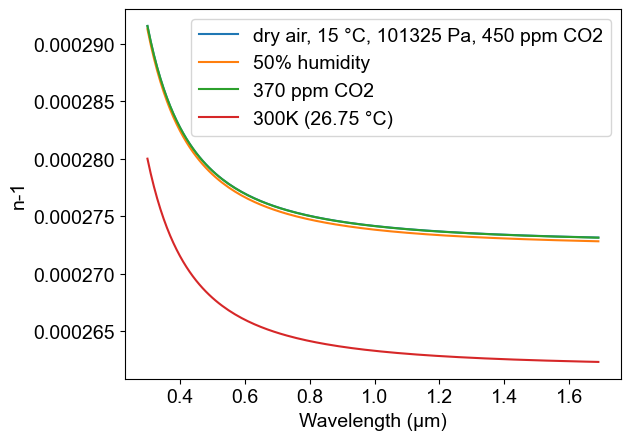

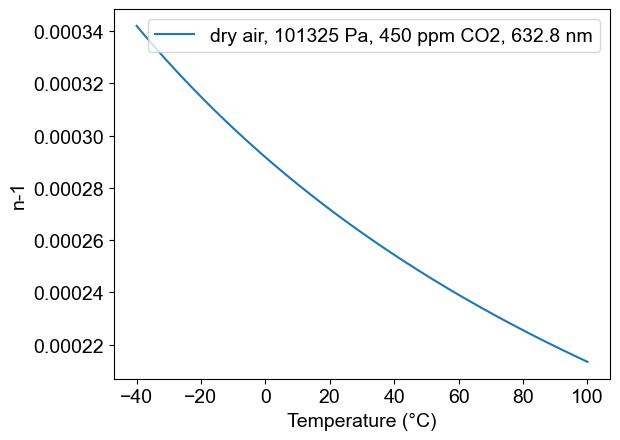

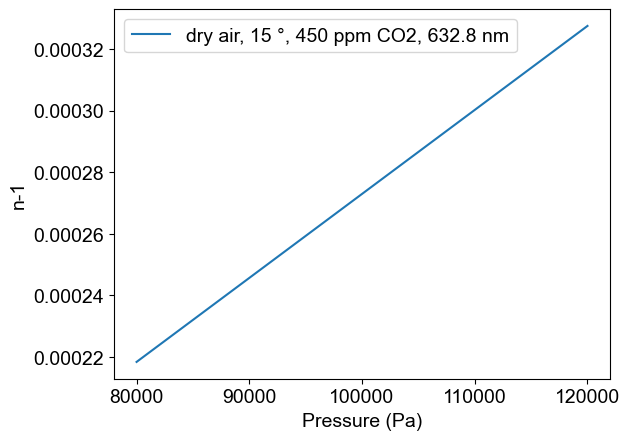

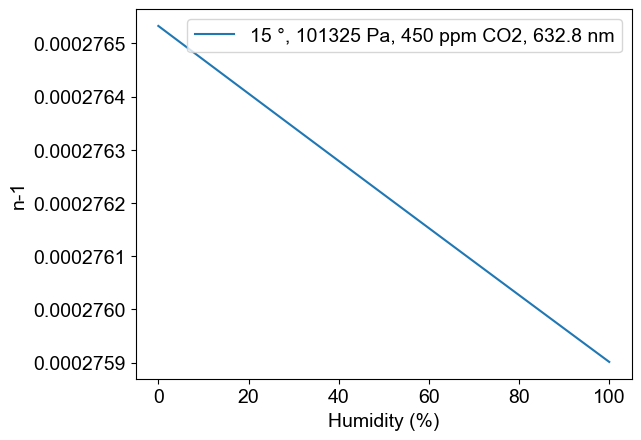

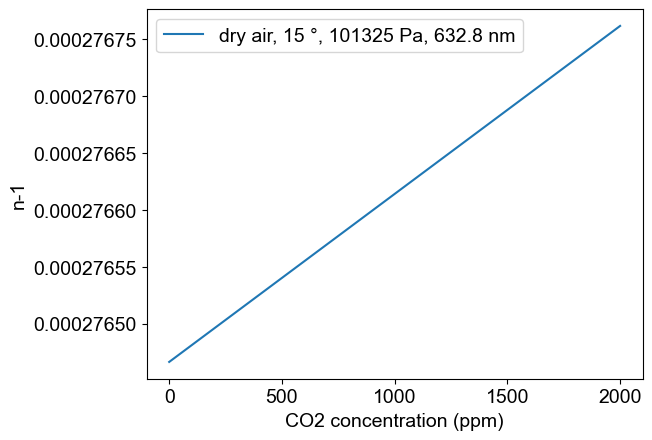

In [15]:
# -*- coding: utf-8 -*-
# Author: Mikhail Polyanskiy
# Last modified: 2017-11-23
# Original data: Ciddor 1996, https://doi.org/10.1364/AO.35.001566

###############################################################################

import numpy as np
import matplotlib.pyplot as plt
π = np.pi


def Z(T,p,xw): #compressibility
    t=T-273.15
    a0 = 1.58123e-6   #K·Pa^-1
    a1 = -2.9331e-8   #Pa^-1
    a2 = 1.1043e-10   #K^-1·Pa^-1
    b0 = 5.707e-6     #K·Pa^-1
    b1 = -2.051e-8    #Pa^-1
    c0 = 1.9898e-4    #K·Pa^-1
    c1 = -2.376e-6    #Pa^-1
    d  = 1.83e-11     #K^2·Pa^-2
    e  = -0.765e-8    #K^2·Pa^-2
    return 1-(p/T)*(a0+a1*t+a2*t**2+(b0+b1*t)*xw+(c0+c1*t)*xw**2) + (p/T)**2*(d+e*xw**2)


def n(λ,t,p,h,xc):
    # λ: wavelength, 0.3 to 1.69 μm 
    # t: temperature, -40 to +100 °C
    # p: pressure, 80000 to 120000 Pa
    # h: fractional humidity, 0 to 1
    # xc: CO2 concentration, 0 to 2000 ppm

    σ = 1/λ           #μm^-1
    
    T= t + 273.15     #Temperature °C -> K
    
    R = 8.314510      #gas constant, J/(mol·K)
    
    k0 = 238.0185     #μm^-2
    k1 = 5792105      #μm^-2
    k2 = 57.362       #μm^-2
    k3 = 167917       #μm^-2
 
    w0 = 295.235      #μm^-2
    w1 = 2.6422       #μm^-2
    w2 = -0.032380    #μm^-4
    w3 = 0.004028     #μm^-6
    
    A = 1.2378847e-5  #K^-2
    B = -1.9121316e-2 #K^-1
    C = 33.93711047
    D = -6.3431645e3  #K
    
    α = 1.00062
    β = 3.14e-8       #Pa^-1,
    γ = 5.6e-7        #°C^-2

    #saturation vapor pressure of water vapor in air at temperature T
    if(t>=0):
        svp = np.exp(A*T**2 + B*T + C + D/T) #Pa
    else:
        svp = 10**(-2663.5/T+12.537)
    
    #enhancement factor of water vapor in air
    f = α + β*p + γ*t**2
    
    #molar fraction of water vapor in moist air
    xw = f*h*svp/p
    
    #refractive index of standard air at 15 °C, 101325 Pa, 0% humidity, 450 ppm CO2
    nas = 1 + (k1/(k0-σ**2)+k3/(k2-σ**2))*1e-8
    
    #refractive index of standard air at 15 °C, 101325 Pa, 0% humidity, xc ppm CO2
    naxs = 1 + (nas-1) * (1+0.534e-6*(xc-450))
    
    #refractive index of water vapor at standard conditions (20 °C, 1333 Pa)
    nws = 1 + 1.022*(w0+w1*σ**2+w2*σ**4+w3*σ**6)*1e-8
    
    Ma = 1e-3*(28.9635 + 12.011e-6*(xc-400)) #molar mass of dry air, kg/mol
    Mw = 0.018015                            #molar mass of water vapor, kg/mol
    
    Za = Z(288.15, 101325, 0)                #compressibility of dry air
    Zw = Z(293.15, 1333, 1)                  #compressibility of pure water vapor
    
    #Eq.4 with (T,P,xw) = (288.15, 101325, 0)
    ρaxs = 101325*Ma/(Za*R*288.15)           #density of standard air
    
    #Eq 4 with (T,P,xw) = (293.15, 1333, 1)
    ρws  = 1333*Mw/(Zw*R*293.15)             #density of standard water vapor
    
    # two parts of Eq.4: ρ=ρa+ρw
    ρa   = p*Ma/(Z(T,p,xw)*R*T)*(1-xw)       #density of the dry component of the moist air    
    ρw   = p*Mw/(Z(T,p,xw)*R*T)*xw           #density of the water vapor component
    
    nprop = 1 + (ρa/ρaxs)*(naxs-1) + (ρw/ρws)*(nws-1)
    
    return nprop



# output - modify code below the line to match your needs
##############################################################################
    
#use this to calculate n at particular conditions
#print("n =",n(0.6328,15,101325,0,450))

#plot n vs μm
λ = np.arange(0.3, 1.691, 0.01)
n1 = n(λ,15,101325,0,450) #dry air, 15 °C, 450 ppm
n2 = n(λ,15,101325,0.5,450) #50% humidity, 15 °C, 450 ppm
n3 = n(λ,15,101325,0,370) #dry air, 15 °C, 370 ppm
n4 = n(λ,26.85,101325,0,450) #dry air, 300K, 450 ppm
plt.rc('font', family='Arial', size='14')
plt.figure(1)
plt.plot(λ, n1-1, label="dry air, 15 °C, 101325 Pa, 450 ppm CO2")
plt.plot(λ, n2-1, label="50% humidity")
plt.plot(λ, n3-1, label="370 ppm CO2")
plt.plot(λ, n4-1, label="300K (26.75 °C)")
plt.xlabel('Wavelength (μm)')
plt.ylabel('n-1')
plt.legend()

t = np.arange(-40, 100.1, 1)
n5 = [None] * len(t)
for i in range(0, len(t)):
    n5[i] = n(0.6328,t[i],101325,0,450)-1 #dry air, 450 ppm @ HeNe wavelength
plt.figure(2)
plt.plot(t, n5, label="dry air, 101325 Pa, 450 ppm CO2, 632.8 nm")
plt.xlabel('Temperature (°C)')
plt.ylabel('n-1')
plt.legend()

p = np.arange(80000, 120001, 250)
n6 = n(0.6328,15,p,0,450) #dry air, 15 °, 450 ppm @ HeNe wavelength
plt.figure(3)
plt.plot(p, n6-1, label="dry air, 15 °, 450 ppm CO2, 632.8 nm")
plt.xlabel('Pressure (Pa)')
plt.ylabel('n-1')
plt.legend()

h = np.arange(0, 1.001, 0.01)
n7 = n(0.6328, 15, 101325, h, 450) #dry air, 15 °, 450 ppm @ HeNe wavelength
plt.figure(4)
plt.plot(h*100, n7-1, label="15 °, 101325 Pa, 450 ppm CO2, 632.8 nm")
plt.xlabel('Humidity (%)')
plt.ylabel('n-1')
plt.legend()

xc = np.arange(0, 2001, 100)
n8 = n(0.6328, 15, 101325, 0, xc) #dry air, 15 °, 450 ppm @ HeNe wavelength
plt.figure(5)
plt.plot(xc, n8-1, label="dry air, 15 °, 101325 Pa, 632.8 nm")
plt.xlabel('CO2 concentration (ppm)')
plt.ylabel('n-1')
plt.legend()